# Requirements

In [ ]:
#!pip install wikipedia-api

# Import Dataset

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("videos.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92759 entries, 0 to 92758
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   kind                  92759 non-null  object 
 1   videoId               92759 non-null  int64  
 2   publishedAt           92759 non-null  object 
 3   channelId             92759 non-null  int64  
 4   title                 92759 non-null  object 
 5   description           35237 non-null  object 
 6   tags                  20891 non-null  object 
 7   defaultLanguage       15785 non-null  object 
 8   defaultAudioLanguage  29956 non-null  object 
 9   contentDuration       91492 non-null  object 
 10  viewCount             91490 non-null  float64
 11  likeCount             86630 non-null  float64
 12  favouriteCount        91492 non-null  float64
 13  commentCount          90294 non-null  float64
 14  topicCategories       91228 non-null  object 
dtypes: float64(4), int6

In [3]:
df.head()

,kind,videoId,publishedAt,channelId,title,description,tags,defaultLanguage,defaultAudioLanguage,contentDuration,viewCount,likeCount,favouriteCount,commentCount,topicCategories
0,youtube#video,85806,2024-01-15 00:59:29+00:00,33807,Unlocking the Benefits of Face Masks for Skin ...,NaN,NaN,en-US,en-US,PT9S,72.0,0.0,0.0,0.0,"['https://en.wikipedia.org/wiki/Health', 'http..."
1,youtube#video,30556,2023-10-27 19:32:16+00:00,46650,Get ready for the Magic💚💜🤍💝✨ #hydration #glowi...,NaN,NaN,NaN,NaN,PT45S,257.0,7.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
2,youtube#video,51771,2024-09-28 01:23:22+00:00,14346,#trending #makeup #beautymakeup #yslbeauty #lu...,NaN,NaN,NaN,en-US,PT19S,164.0,4.0,0.0,2.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
3,youtube#video,45298,2023-07-13 15:19:28+00:00,50139,#shortvedio #balayage,NaN,NaN,NaN,NaN,PT14S,1207.0,20.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
4,youtube#video,43611,2023-04-29 18:47:37+00:00,8143,Full Face of Merit Beauty 🤎 featuring new Flus...,NaN,NaN,NaN,en,PT56S,8647.0,268.0,0.0,7.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...


# Formatting and Cleaning

In [4]:
print(df['kind'].unique())

df.drop('kind', axis=1, inplace=True)

['youtube#video']


In [5]:
df['publishedAt'] = pd.to_datetime(df['publishedAt'])

In [6]:
from datetime import timedelta
import re

# Function to convert ISO 8601 duration string to total seconds
def convert_duration_to_seconds(duration_str):
    if not isinstance(duration_str, str):
        return None

    # Use regular expressions to find hours, minutes, and seconds
    hours = re.search(r'(\d+)H', duration_str)
    minutes = re.search(r'(\d+)M', duration_str)
    seconds = re.search(r'(\d+)S', duration_str)

    h = int(hours.group(1)) if hours else 0
    m = int(minutes.group(1)) if minutes else 0
    s = int(seconds.group(1)) if seconds else 0

    return timedelta(hours=h, minutes=m, seconds=s).total_seconds()

# Apply the conversion function to the 'contentDuration' column
df['contentDuration_seconds'] = df['contentDuration'].apply(convert_duration_to_seconds)

# Feature Generation

## 1. Topic Extraction and Wikipedia Enrichment

In [7]:
# Extract the topic out from the Wikipedia URLs
import ast

def extract_topic_from_wiki(url_list):
    if pd.isna(url_list):
        return []

    # If it's a string that looks like a list, safely parse it
    if isinstance(url_list, str):
        try:
            parsed = ast.literal_eval(url_list)
            if isinstance(parsed, list):
                url_list = parsed
            else:
                url_list = [url_list]
        except Exception:
            url_list = [url_list]

    topics = []
    for url in url_list:
        if not isinstance(url, str):
            continue
        topic = url.split("/")[-1]              # take last part
        topic = topic.replace("_", " ").strip() # underscores → spaces
        topic = topic.strip("']")               # remove trailing ' or ]
        topics.append(topic)

    return topics

df['topicCleaned'] = df['topicCategories'].apply(extract_topic_from_wiki)

In [8]:
#List all the unique topics/categories in this dataset
all_topics = set([t for sublist in df['topicCleaned'] for t in sublist if isinstance(sublist, list)])
print("Total unique topics:", len(all_topics))
print(sorted(all_topics))

Total unique topics: 45
['Action game', 'Action-adventure game', 'Basketball', 'Business', 'Casual game', 'Country music', 'Cricket', 'Electronic music', 'Entertainment', 'Fashion', 'Film', 'Food', 'Health', 'Hip hop music', 'Hobby', 'Humour', 'Jazz', 'Knowledge', 'Lifestyle (sociology)', 'Military', 'Mixed martial arts', 'Music', 'Music of Asia', 'Music of Latin America', 'Performing arts', 'Pet', 'Physical attractiveness', 'Physical fitness', 'Politics', 'Pop music', 'Puzzle video game', 'Religion', 'Rhythm and blues', 'Role-playing video game', 'Society', 'Soul music', 'Sport', 'Sports game', 'Strategy video game', 'Technology', 'Television program', 'Tennis', 'Tourism', 'Vehicle', 'Video game culture']


## 2. Like-View ratio, Comment-view Ratio

In [9]:
df['like_view_ratio'] = np.where(df['viewCount']>0, df['likeCount'] / df['viewCount'], np.nan)
df['comment_view_ratio'] = np.where(df['viewCount']>0, df['commentCount'] / df['viewCount'], np.nan)

## 3. Video duration segmentation

In [10]:
bins = [0, 30, 120, 300, 900, 3600, np.inf]
labels = ['<30s', '30-120s', '2-5m', '5-15m', '15-60m', '>60m']
try:
  df['length_bucket'] = pd.cut(df['contentDuration_seconds'].fillna(-1), bins=[-1,30,120,300,900,3600,10**9], labels=labels)
except Exception:
  df['length_bucket'] = 'unknown'

## 4. Tags Cleaning

In [11]:
def extract_hashtags(text):
  if pd.isna(text):
    return []
  return re.findall(r"#(\w+)", str(text))

hashtags_from_title = df['title'].apply(extract_hashtags) if 'title' in df.columns else [[] for _ in range(len(df))]
hashtags_from_desc = df['description'].apply(extract_hashtags) if 'description' in df.columns else [[] for _ in range(len(df))]

def ensure_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    return [x]

merged_tags = []
for base, ht1, ht2 in zip(df['tags'], hashtags_from_title, hashtags_from_desc):
  base = ensure_list(base)
  ht1 = ensure_list(ht1)
  ht2 = ensure_list(ht2)
  merged = list(set(base) | set(ht1) | set(ht2))
  merged_tags.append(merged)


df['tags'] = merged_tags

In [12]:
# Attempt to enrich dataset with more information from wikipedia
import wikipediaapi
import requests

import urllib.parse
from datetime import datetime

def get_wiki_pageviews(page_title, start="20230101", end=None):
    if end is None:
        # default to today's date in YYYYMMDD
        end = datetime.today().strftime("%Y%m%d")

    # Encode title properly for Wikimedia API
    encoded_title = urllib.parse.quote(page_title, safe="")

    url = f"https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/{encoded_title}/daily/{start}/{end}"
    r = requests.get(url)

    if r.status_code == 200:
        data = r.json().get("items", [])
        if data:
            return sum(item["views"] for item in data)
    return 0  # return 0 instead of None if no data

wiki_wiki = wikipediaapi.Wikipedia(user_agent="LoReal (ryanchinjh@gmail.com)", language='en')



def enrich_wiki_topic(topic_url):
    try:
        topic = topic_url.split("/")[-1]
        page_title = topic  # keep underscores
        page = wiki_wiki.page(topic.replace("_", " "))
        summary = page.summary[0:500] if page.exists() else None
        pageviews = get_wiki_pageviews(page_title)
        return {
            "topic": topic.replace("_", " "),
            #"summary": summary,
            "categories": list(page.categories.keys()) if page.exists() else [],
            "pageviews": pageviews
        }
    except Exception:
        return {"topic": None, "summary": None, "categories": [], "pageviews": 0}

print(enrich_wiki_topic("https://en.wikipedia.org/wiki/Lifestyle_(sociology)"))

{'topic': 'Lifestyle (sociology)', 'categories': ['Category:1920s neologisms', 'Category:Articles containing German-language text', 'Category:Articles with short description', 'Category:Lifestyle', 'Category:Personal life', 'Category:Philosophy of life', 'Category:Short description matches Wikidata', 'Category:Sociological terminology', 'Category:Subcultures', 'Category:Webarchive template wayback links', 'Category:Wikipedia indefinitely semi-protected pages'], 'pageviews': 0}


**Note: Page views still don't work. Will look into it more later**

# Creating separate dataframe for channel stats

In [13]:
channel_df = df.groupby('channelId')['viewCount'].sum()

In [14]:
channel_agg = df.groupby('channelId').agg(
    total_view=('viewCount', 'sum'),
    average_view=('viewCount', 'mean'),
    video_count = ('channelId', 'count')
).reset_index()

q = channel_agg['average_view'].quantile([0.33,0.66]).to_list()
small_th, medium_th = q[0], q[1]


def channel_size_label(avg):
  if pd.isna(avg):
    return 'unknown'
  if avg <= small_th:
    return 'small'
  if avg <= medium_th:
    return 'medium'
  return 'large'

channel_agg['channel_size'] = channel_agg['average_view'].apply(channel_size_label)

channel_agg.head(10)

,channelId,total_view,average_view,video_count,channel_size
0,0,546.0,546.0,1,medium
1,1,850374.0,850374.0,1,large
2,2,253.0,253.0,1,small
3,3,459.0,459.0,1,medium
4,4,4.0,4.0,1,small
5,5,10.0,10.0,1,small
6,6,1535.0,767.5,2,medium
7,7,113.0,113.0,1,small
8,8,609.0,609.0,1,medium
9,9,549.0,274.5,2,small


# EDA

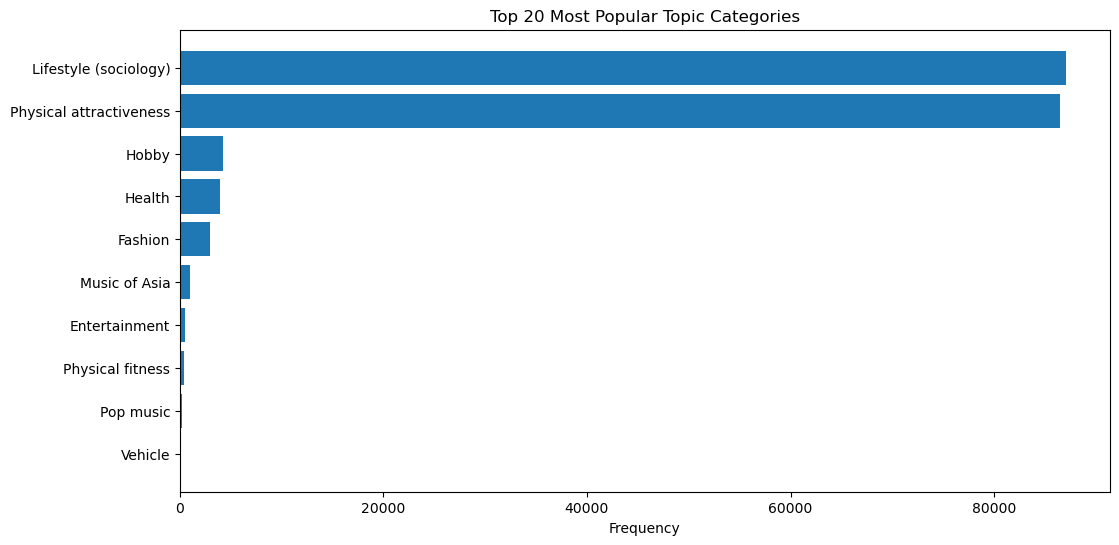

In [15]:
from collections import Counter
all_topics = [t for sublist in df['topicCleaned'] for t in sublist if isinstance(sublist, list)]
topic_counts = Counter(all_topics)

# Get top 10 categories
top_topics = topic_counts.most_common(10)

# Separate labels and values
labels, values = zip(*top_topics)

# Plot
plt.figure(figsize=(12,6))
plt.barh(labels, values)
plt.xlabel("Frequency")
plt.title("Top 20 Most Popular Topic Categories")
plt.gca().invert_yaxis()  # largest on top
plt.show()

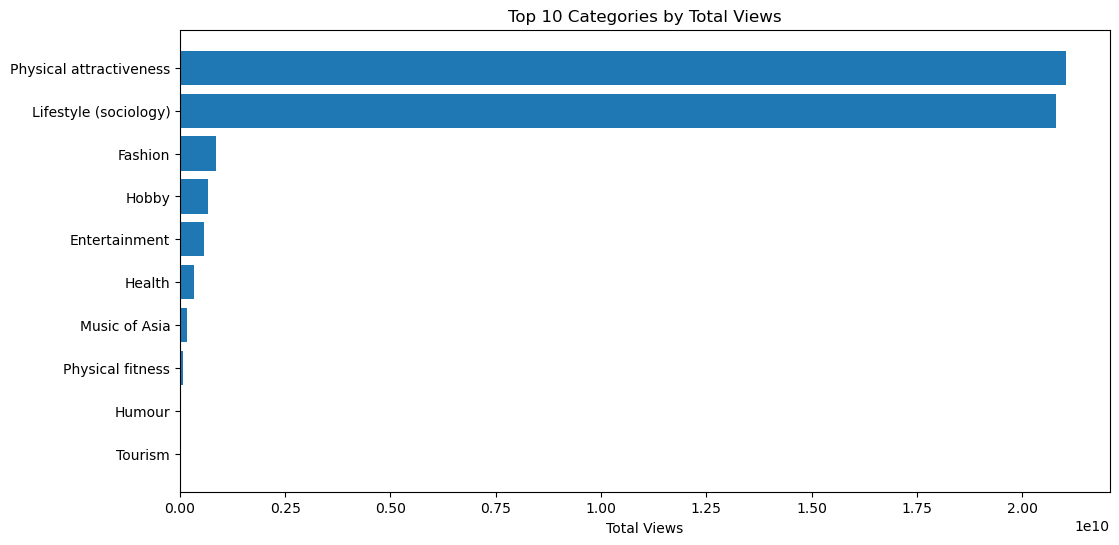

In [16]:
from collections import defaultdict
category_views = defaultdict(int)

# Sum views per category
for cats, views in zip(df['topicCleaned'], df['viewCount']):
    if not isinstance(cats, list):
        continue
    try:
        v = int(views)
    except Exception:
        v = 0
    for c in cats:
        category_views[c] += v

# Sort and take top 10
top_by_views = sorted(category_views.items(), key=lambda x: x[1], reverse=True)[:10]
labels, values = zip(*top_by_views)

# Plot
plt.figure(figsize=(12,6))
plt.barh(labels, values)
plt.xlabel("Total Views")
plt.title("Top 10 Categories by Total Views")
plt.gca().invert_yaxis()
plt.show()

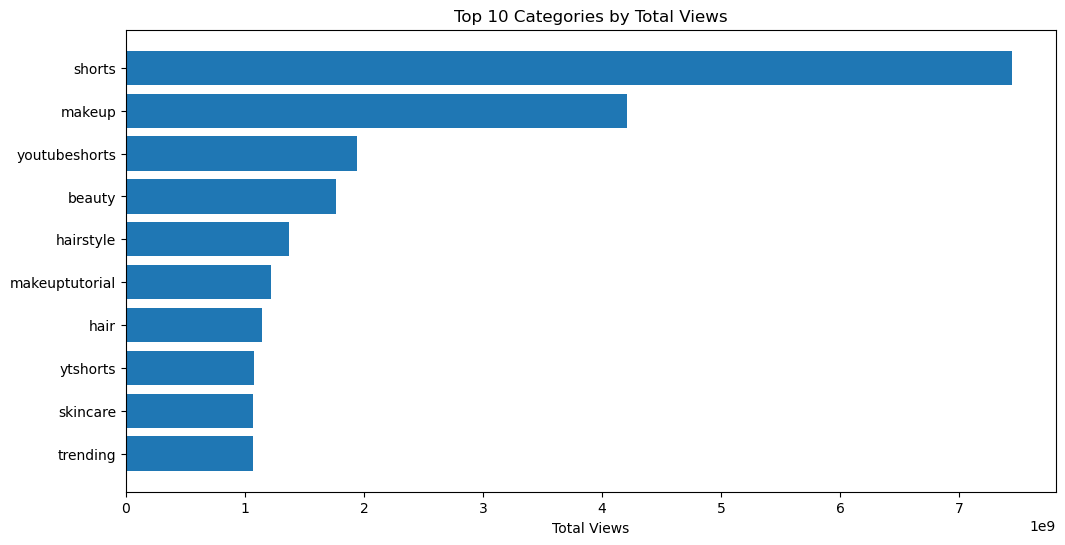

In [17]:
tags_views = defaultdict(int)

# Sum views per category
for tags, views in zip(df['tags'], df['viewCount']):
    if not isinstance(cats, list):
        continue
    try:
        v = int(views)
    except Exception:
        v = 0
    for t in tags:
        tags_views[t] += v

# Sort and take top 10
top_by_views = sorted(tags_views.items(), key=lambda x: x[1], reverse=True)[:10]
labels, values = zip(*top_by_views)

# Plot
plt.figure(figsize=(12,6))
plt.barh(labels, values)
plt.xlabel("Total Views")
plt.title("Top 10 Categories by Total Views")
plt.gca().invert_yaxis()
plt.show()

In [18]:
df['upload_month'] = df['publishedAt'].dt.to_period('M').apply(lambda r: r.start_time.date())

C:\Users\maxyj\AppData\Local\Temp\ipykernel_22916\1688453371.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['upload_month'] = df['publishedAt'].dt.to_period('M').apply(lambda r: r.start_time.date())


C:\Users\maxyj\AppData\Local\Temp\ipykernel_22916\171908774.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_exploded['month'] = df_exploded['publishedAt'].dt.to_period('M')


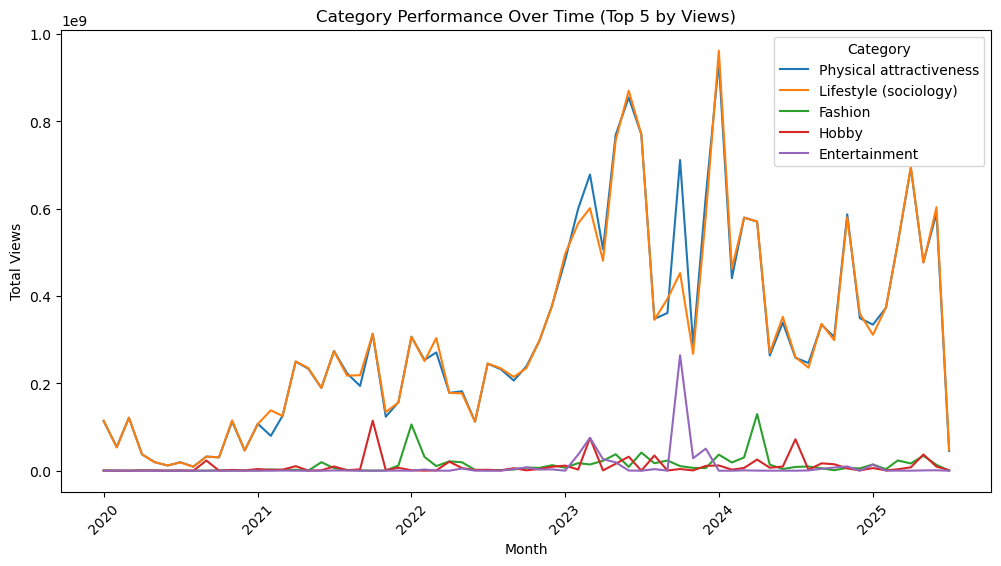

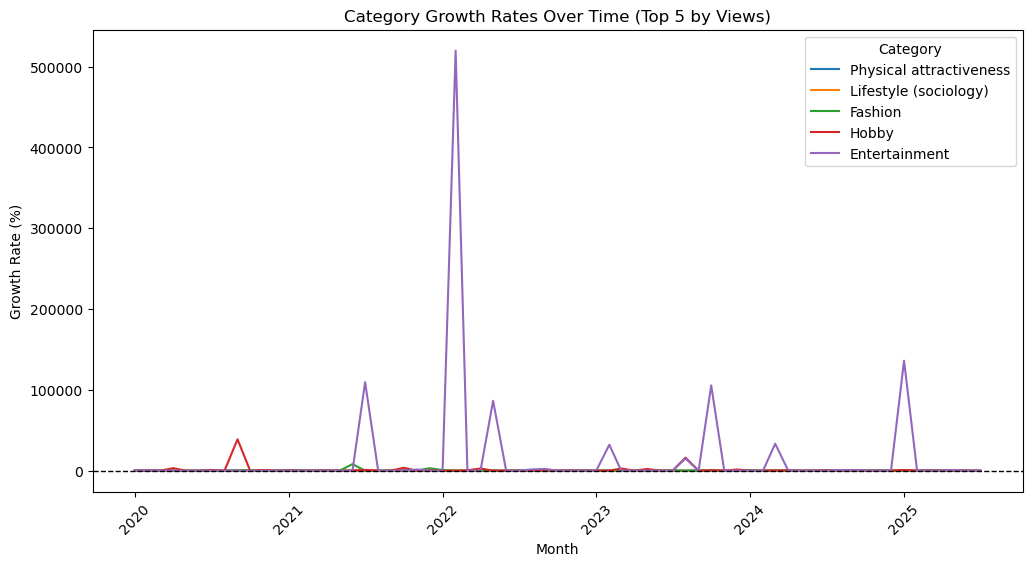

In [19]:
# Explode categories so each video-category pair becomes its own row
df_exploded = df.explode('topicCleaned')
df_exploded = df_exploded.dropna(subset=['topicCleaned'])

# Group by month and category
df_exploded['month'] = df_exploded['publishedAt'].dt.to_period('M')
cat_time = (
    df_exploded.groupby(['upload_month','topicCleaned'])['viewCount']
    .sum()
    .reset_index()
)

# Pivot for plotting
cat_pivot = cat_time.pivot(index='upload_month', columns='topicCleaned', values='viewCount').fillna(0)

# Compute growth rate = percentage change month-to-month
cat_growth = cat_pivot.pct_change().replace([np.inf, -np.inf], np.nan).fillna(0)

# Plot top 5 categories by total views
top5_cats = cat_pivot.sum().sort_values(ascending=False).head(5).index
cat_pivot[top5_cats].plot(figsize=(12,6))
plt.title("Category Performance Over Time (Top 5 by Views)")
plt.ylabel("Total Views")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.legend(title="Category")
plt.show()

# ---- Plot Growth Rates ----
plt.figure(figsize=(12,6))
(cat_growth[top5_cats] * 100).plot(ax=plt.gca())
plt.title("Category Growth Rates Over Time (Top 5 by Views)")
plt.ylabel("Growth Rate (%)")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.legend(title="Category")
plt.show()

C:\Users\maxyj\AppData\Local\Temp\ipykernel_22916\3686110200.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_exploded['month'] = df_exploded['publishedAt'].dt.to_period('M')


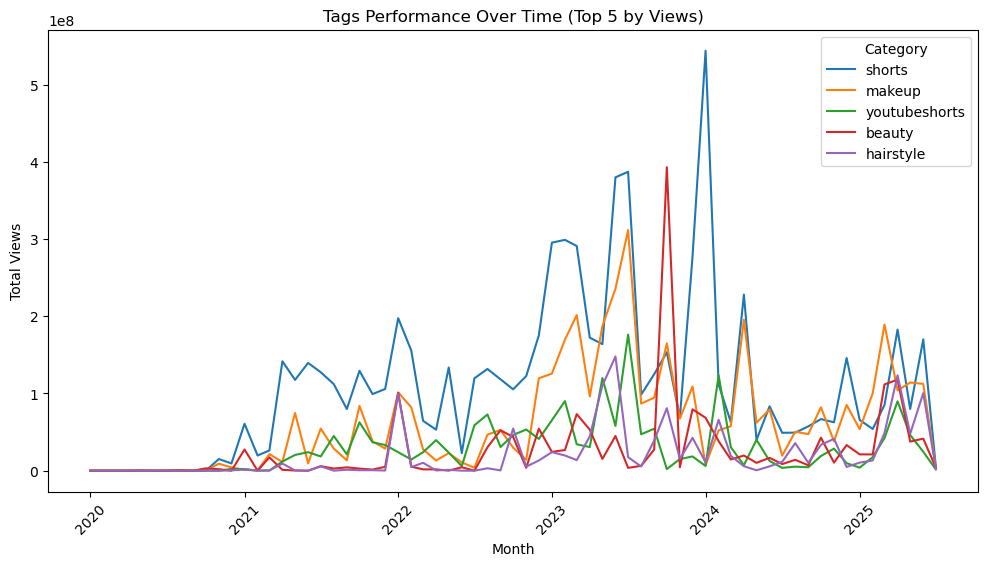

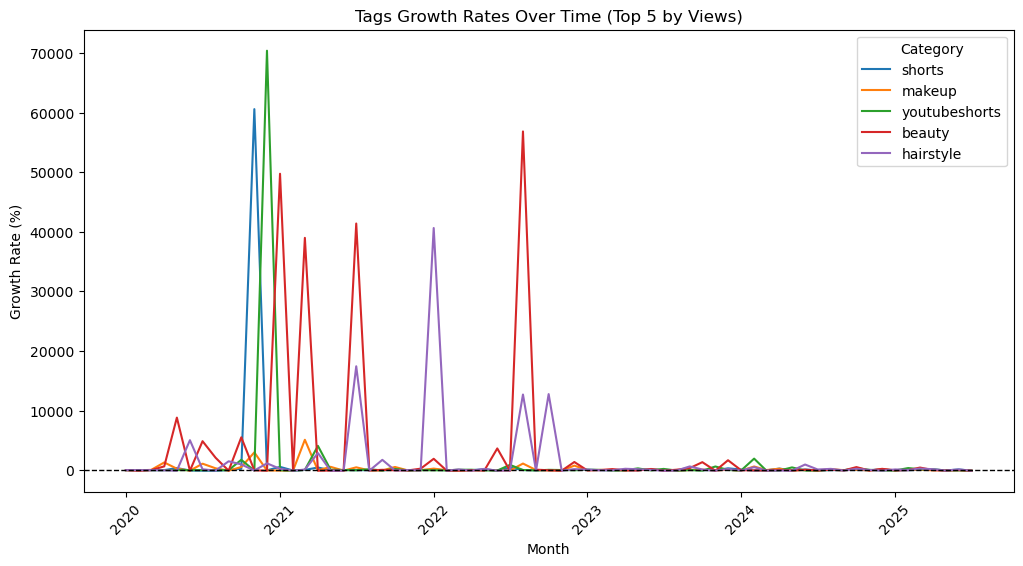

In [20]:
# Explode categories so each video-category pair becomes its own row
df_exploded = df.explode('tags')
df_exploded = df_exploded.dropna(subset=['tags'])

# Group by month and category
df_exploded['month'] = df_exploded['publishedAt'].dt.to_period('M')
tag_time = (
    df_exploded.groupby(['upload_month','tags'])['viewCount']
    .sum()
    .reset_index()
)

# Pivot for plotting
tag_pivot = tag_time.pivot(index='upload_month', columns='tags', values='viewCount').fillna(0)

tag_growth = tag_pivot.pct_change().replace([np.inf, -np.inf], np.nan).fillna(0)

# Plot top 5 tags by total views
top5_tags = tag_pivot.sum().sort_values(ascending=False).head(5).index
tag_pivot[top5_tags].plot(figsize=(12,6))
plt.title("Tags Performance Over Time (Top 5 by Views)")
plt.ylabel("Total Views")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.legend(title="Category")
plt.show()

# ---- Plot Growth Rates ----
plt.figure(figsize=(12,6))
(tag_growth[top5_tags] * 100).plot(ax=plt.gca())
plt.title("Tags Growth Rates Over Time (Top 5 by Views)")
plt.ylabel("Growth Rate (%)")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.legend(title="Category")
plt.show()

In [21]:
# Expand categories
df_exploded = df.explode('topicCleaned').dropna(subset=['topicCleaned'])
df_exploded['month'] = df_exploded['publishedAt'].dt.to_period('M')

# Aggregate views
cat_time = (
    df_exploded.groupby(['month','topicCleaned'])['viewCount']
    .sum()
    .reset_index()
)

# Pivot into time series
cat_pivot = cat_time.pivot(index='month', columns='topicCleaned', values='viewCount').fillna(0)

entry_decay_points = {}

for cat in cat_pivot.columns:
    series = cat_pivot[cat].astype(float)
    growth = series.pct_change().replace([np.inf, -np.inf], np.nan).fillna(0)

    entry, decay = None, None

    # Entry: first month with big positive growth (>50% increase over previous month)
    for date, g in growth.items():
        if g > 0.5 and entry is None:
            entry = date
            break

    # Decay: first month after entry with strong decline (< -30%)
    if entry:
        after_entry = growth[series.index >= entry]
        for date, g in after_entry.items():
            if g < -0.3:
                decay = date
                break

    entry_decay_points[cat] = {"entry": entry, "decay": decay}

# Convert to DataFrame for easier inspection
entry_decay_df = (
    pd.DataFrame(entry_decay_points).T
    .reset_index()
    .rename(columns={"index": "category"})
)

print("Entry & Decay Points Detected:")
print(entry_decay_df.head(20))

Entry & Decay Points Detected:
                 category    entry    decay
0             Action game     None     None
1   Action-adventure game     None     None
2              Basketball     None     None
3                Business     None     None
4             Casual game     None     None
5           Country music     None     None
6                 Cricket     None     None
7        Electronic music  2025-06  2025-07
8           Entertainment  2020-02  2020-03
9                 Fashion  2020-04  2020-06
10                   Film  2020-02  2020-03
11                   Food  2025-06  2025-07
12                 Health  2020-02  2020-03
13          Hip hop music  2021-07  2021-08
14                  Hobby  2020-02  2020-03
15                 Humour  2023-01  2023-02
16                   Jazz     None     None
17              Knowledge  2020-02  2020-03
18  Lifestyle (sociology)  2020-03  2020-04
19               Military     None     None


C:\Users\maxyj\AppData\Local\Temp\ipykernel_22916\3292859334.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_exploded['month'] = df_exploded['publishedAt'].dt.to_period('M')


# Established Trends Analysis

## Measuring Consistency and Stability of Categories/Tags

We'll identify "established" trends by measuring:
1. **Consistency Score**: Low variance in monthly performance
2. **Longevity**: How many months a category/tag has been active
3. **Trend Stability**: Linear trend strength and direction
4. **Market Share Stability**: Consistent proportion of total views

In [22]:
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler

def analyze_established_trends(pivot_data, min_months=6, min_total_views=100000):
    """
    Analyze categories/tags for established trend characteristics
    
    Parameters:
    - pivot_data: Time series data (months x categories/tags)
    - min_months: Minimum number of active months to be considered
    - min_total_views: Minimum total views to be considered significant
    """
    
    results = []
    
    for category in pivot_data.columns:
        series = pivot_data[category]
        
        # Filter out categories with insufficient data
        active_months = (series > 0).sum()
        total_views = series.sum()
        
        if active_months < min_months or total_views < min_total_views:
            continue
            
        # Calculate metrics
        non_zero_series = series[series > 0]
        
        # 1. Consistency Score (inverse of coefficient of variation)
        if non_zero_series.std() > 0:
            cv = non_zero_series.std() / non_zero_series.mean()
            consistency_score = 1 / (1 + cv)  # Higher = more consistent
        else:
            consistency_score = 1.0
        
        # 2. Longevity Score (months active / total months)
        longevity_score = active_months / len(series)
        
        # 3. Trend Stability (R-squared of linear regression)
        x_vals = np.arange(len(non_zero_series))
        if len(non_zero_series) > 1:
            slope, intercept, r_value, p_value, std_err = linregress(x_vals, non_zero_series.values)
            trend_stability = r_value ** 2  # R-squared
            trend_direction = 'positive' if slope > 0 else 'negative' if slope < 0 else 'flat'
        else:
            trend_stability = 0
            trend_direction = 'insufficient_data'
        
        # 4. Market Share Stability (consistency of market share over time)
        monthly_totals = pivot_data.sum(axis=1)
        market_share = series / monthly_totals
        market_share_active = market_share[series > 0]
        
        if len(market_share_active) > 1 and market_share_active.std() > 0:
            market_share_cv = market_share_active.std() / market_share_active.mean()
            market_share_stability = 1 / (1 + market_share_cv)
        else:
            market_share_stability = 1.0
        
        # 5. Growth Stability (consistency of growth rates)
        growth_rates = series.pct_change().dropna()
        growth_rates = growth_rates[~np.isinf(growth_rates)]
        
        if len(growth_rates) > 1 and growth_rates.std() > 0:
            growth_volatility = growth_rates.std()
            growth_stability = 1 / (1 + growth_volatility)
        else:
            growth_stability = 1.0
        
        # 6. Peak-to-Average Ratio (lower = more stable)
        peak_to_avg_ratio = non_zero_series.max() / non_zero_series.mean()
        stability_from_peaks = 1 / peak_to_avg_ratio  # Normalize
        
        # Composite Established Score (weighted average)
        established_score = (
            0.25 * consistency_score +
            0.20 * longevity_score +
            0.15 * trend_stability +
            0.15 * market_share_stability +
            0.15 * growth_stability +
            0.10 * stability_from_peaks
        )
        
        results.append({
            'category': category,
            'total_views': total_views,
            'active_months': active_months,
            'avg_monthly_views': non_zero_series.mean(),
            'consistency_score': consistency_score,
            'longevity_score': longevity_score,
            'trend_stability': trend_stability,
            'trend_direction': trend_direction,
            'market_share_stability': market_share_stability,
            'growth_stability': growth_stability,
            'peak_to_avg_ratio': peak_to_avg_ratio,
            'established_score': established_score
        })
    
    return pd.DataFrame(results)

# Analyze categories
print("=== ANALYZING ESTABLISHED CATEGORIES ===")
established_categories = analyze_established_trends(cat_pivot)
established_categories = established_categories.sort_values('established_score', ascending=False)

print(f"\nTop 15 Most Established Categories:")
print(established_categories.head(15)[['category', 'total_views', 'active_months', 
                                      'consistency_score', 'longevity_score', 
                                      'trend_stability', 'established_score']].round(3))

=== ANALYZING ESTABLISHED CATEGORIES ===

Top 15 Most Established Categories:
                   category   total_views  active_months  consistency_score  \
17  Physical attractiveness  2.103604e+10             67              0.579   
12    Lifestyle (sociology)  2.079429e+10             67              0.584   
19                 Politics  5.743400e+05              6              0.618   
0               Action game  2.758850e+05              6              0.524   
5                   Fashion  8.656079e+08             67              0.375   
1     Action-adventure game  2.743590e+05              6              0.521   
2                  Business  2.447930e+05              6              0.298   
26       Video game culture  3.463070e+05             10              0.471   
7                    Health  3.222323e+08             67              0.348   
18         Physical fitness  7.910709e+07             61              0.355   
9                     Hobby  6.684516e+08            

In [23]:
# Analyze tags
print("\n=== ANALYZING ESTABLISHED TAGS ===")
established_tags = analyze_established_trends(tag_pivot, min_months=4, min_total_views=50000)
established_tags = established_tags.sort_values('established_score', ascending=False)

print(f"\nTop 15 Most Established Tags:")
print(established_tags.head(15)[['category', 'total_views', 'active_months', 
                                'consistency_score', 'longevity_score', 
                                'trend_stability', 'established_score']].round(3))


=== ANALYZING ESTABLISHED TAGS ===

Top 15 Most Established Tags:
              category  total_views  active_months  consistency_score  \
5204          vpartwig      84393.0              4              0.573   
1949    effortlesschic     301604.0              4              0.558   
404   IndianBeautyGuru     109052.0              4              0.588   
723     TilburyProTeam      50841.0              4              0.551   
4373         sharktank      53593.0              4              0.662   
5294        wigstylist      63540.0              6              0.676   
70        AlipearlHair     258349.0              5              0.521   
1296      blackmenhair     208853.0              4              0.543   
4555       shrotsvideo   51103731.0              4              0.499   
2299              genz     702616.0              4              0.505   
2322          girlgang     665925.0              4              0.480   
3879         nyadollie     194972.0              4       

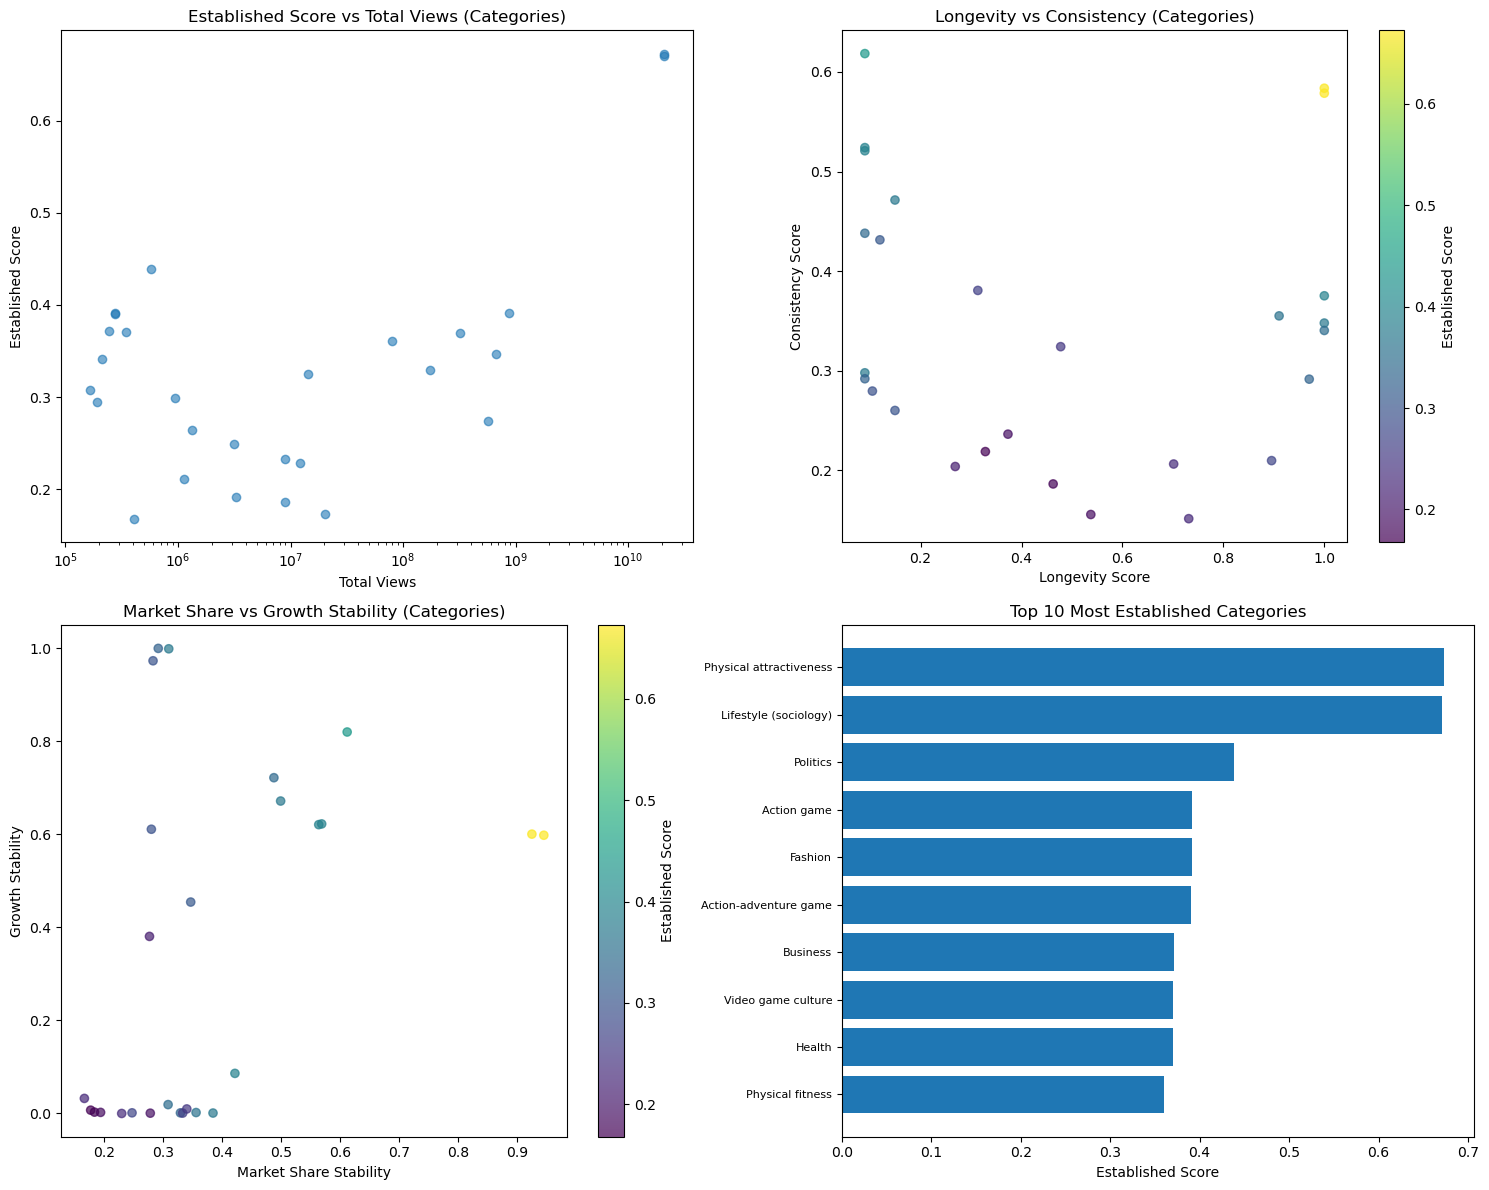

In [24]:
# Visualize Established vs Emerging Categories
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Established Score vs Total Views
ax1.scatter(established_categories['total_views'], established_categories['established_score'], alpha=0.6)
ax1.set_xlabel('Total Views')
ax1.set_ylabel('Established Score')
ax1.set_title('Established Score vs Total Views (Categories)')
ax1.set_xscale('log')

# 2. Consistency vs Longevity
ax2.scatter(established_categories['longevity_score'], established_categories['consistency_score'], 
           c=established_categories['established_score'], cmap='viridis', alpha=0.7)
ax2.set_xlabel('Longevity Score')
ax2.set_ylabel('Consistency Score')
ax2.set_title('Longevity vs Consistency (Categories)')
plt.colorbar(ax2.collections[0], ax=ax2, label='Established Score')

# 3. Market Share Stability vs Growth Stability
ax3.scatter(established_categories['market_share_stability'], established_categories['growth_stability'],
           c=established_categories['established_score'], cmap='viridis', alpha=0.7)
ax3.set_xlabel('Market Share Stability')
ax3.set_ylabel('Growth Stability')
ax3.set_title('Market Share vs Growth Stability (Categories)')
plt.colorbar(ax3.collections[0], ax=ax3, label='Established Score')

# 4. Top Established Categories Bar Chart
top_established = established_categories.head(10)
ax4.barh(range(len(top_established)), top_established['established_score'])
ax4.set_yticks(range(len(top_established)))
ax4.set_yticklabels(top_established['category'], fontsize=8)
ax4.set_xlabel('Established Score')
ax4.set_title('Top 10 Most Established Categories')
ax4.invert_yaxis()

plt.tight_layout()
plt.show()

=== DETAILED ANALYSIS OF ESTABLISHED CATEGORIES ===


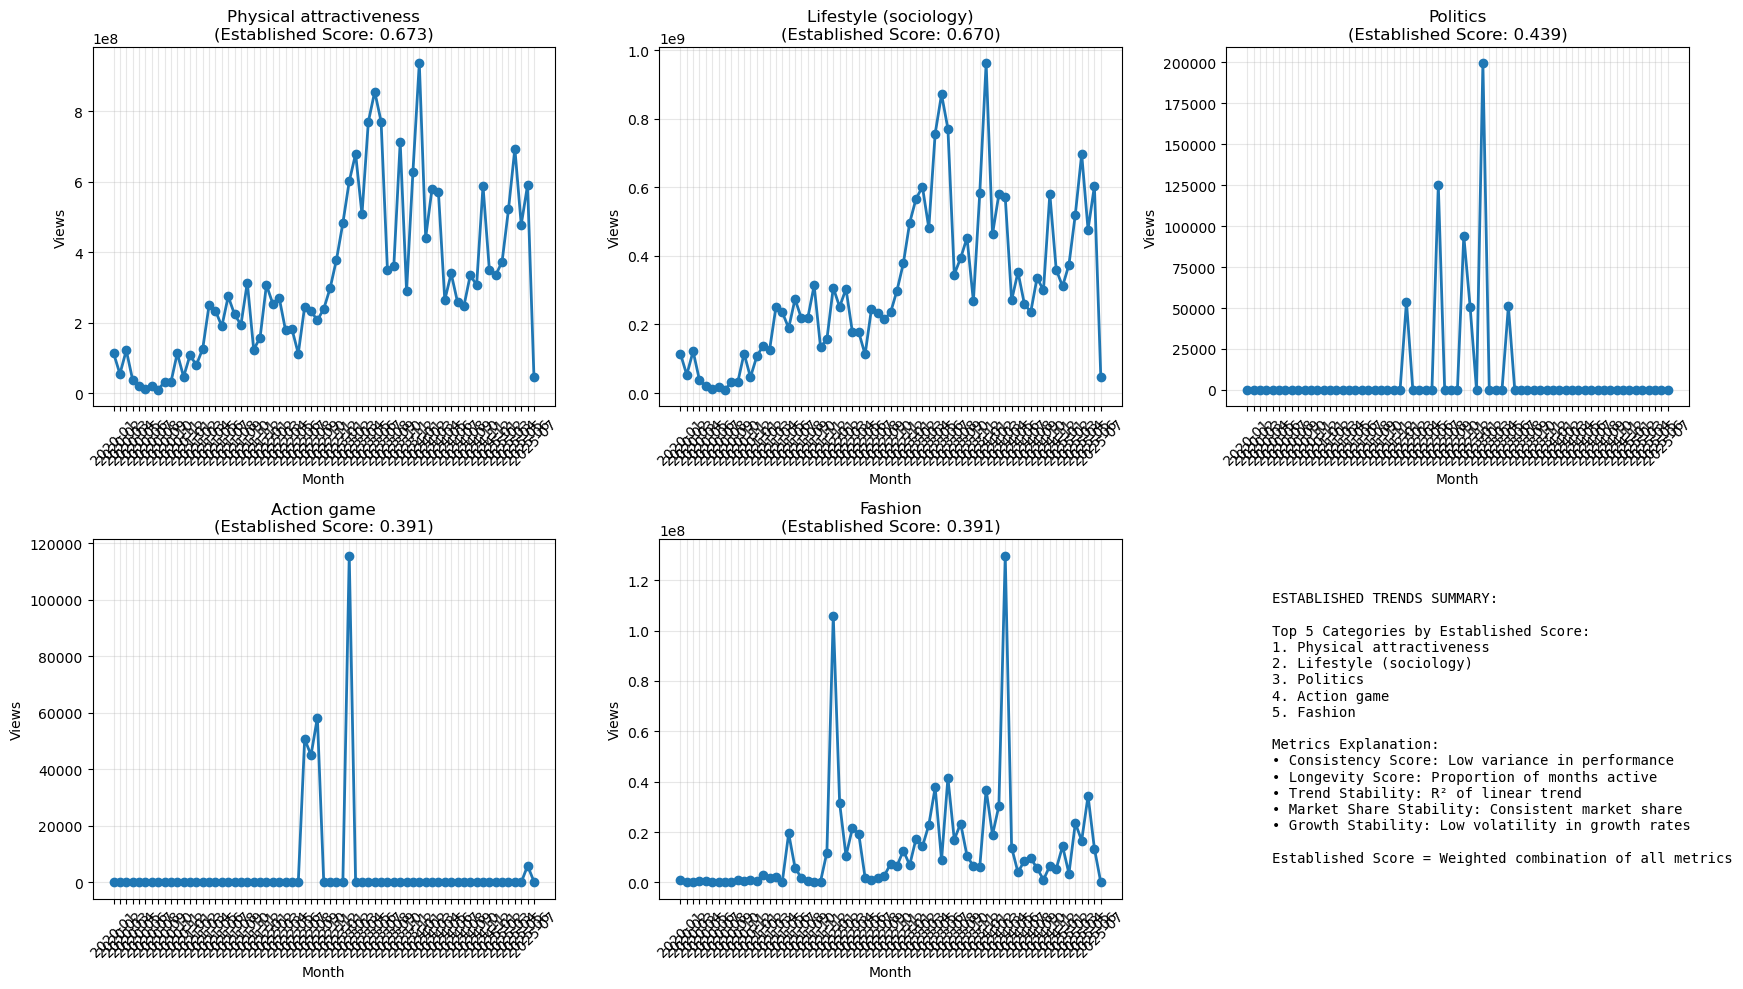


=== COMPARISON: MOST vs LEAST ESTABLISHED ===

MOST ESTABLISHED (Top 3):
                   category   total_views  consistency_score  longevity_score  \
17  Physical attractiveness  2.103604e+10              0.579             1.00   
12    Lifestyle (sociology)  2.079429e+10              0.584             1.00   
19                 Politics  5.743400e+05              0.618             0.09   

    trend_stability  established_score  
17            0.419              0.673  
12            0.423              0.670  
19            0.022              0.439  

LEAST ESTABLISHED (Bottom 3):
           category  total_views  consistency_score  longevity_score  \
13            Music    8935303.0              0.156            0.537   
10           Humour   20321387.0              0.186            0.463   
15  Performing arts     403222.0              0.219            0.328   

    trend_stability  established_score  
13            0.048              0.186  
10            0.009              0.

In [25]:
# Detailed Analysis of Top Established Categories
print("=== DETAILED ANALYSIS OF ESTABLISHED CATEGORIES ===")

# Get top 5 most established categories
top_established_cats = established_categories.head(5)['category'].tolist()

# Plot their time series
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, cat in enumerate(top_established_cats):
    ax = axes[i]
    series = cat_pivot[cat]
    
    # Plot raw views
    ax.plot(series.index.astype(str), series.values, marker='o', linewidth=2)
    ax.set_title(f'{cat}\n(Established Score: {established_categories[established_categories["category"]==cat]["established_score"].iloc[0]:.3f})')
    ax.set_xlabel('Month')
    ax.set_ylabel('Views')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

# Add summary statistics in the last subplot
ax = axes[5]
ax.axis('off')

summary_text = f"""
ESTABLISHED TRENDS SUMMARY:

Top 5 Categories by Established Score:
{chr(10).join([f"{i+1}. {cat}" for i, cat in enumerate(top_established_cats)])}

Metrics Explanation:
• Consistency Score: Low variance in performance
• Longevity Score: Proportion of months active
• Trend Stability: R² of linear trend
• Market Share Stability: Consistent market share
• Growth Stability: Low volatility in growth rates

Established Score = Weighted combination of all metrics
"""

ax.text(0.1, 0.9, summary_text, transform=ax.transAxes, fontsize=10, 
        verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

# Show characteristics of most vs least established
print("\n=== COMPARISON: MOST vs LEAST ESTABLISHED ===")
print("\nMOST ESTABLISHED (Top 3):")
print(established_categories.head(3)[['category', 'total_views', 'consistency_score', 
                                     'longevity_score', 'trend_stability', 'established_score']].round(3))

print("\nLEAST ESTABLISHED (Bottom 3):")
print(established_categories.tail(3)[['category', 'total_views', 'consistency_score', 
                                     'longevity_score', 'trend_stability', 'established_score']].round(3))

# Deep Dive: Established Tags Analysis

## Focus on High-Performance, Consistent, Long-Duration Tags

We'll identify tags that demonstrate:
1. **High absolute view counts** (popularity)
2. **Consistent performance** (low volatility) 
3. **Long-term presence** (sustained over many months)
4. **Stable market share** (reliable portion of total views)

In [26]:
# Enhanced analysis for established tags with stricter criteria
def analyze_high_performance_tags(pivot_data, min_months=6, min_total_views=500000, min_avg_monthly=50000):
    """
    Identify truly established tags with high performance criteria
    
    Parameters:
    - min_months: Minimum active months (6+ for established presence)
    - min_total_views: Minimum total views (500K+ for high performance)
    - min_avg_monthly: Minimum average monthly views when active (50K+ for consistency)
    """
    
    results = []
    
    for tag in pivot_data.columns:
        series = pivot_data[tag]
        
        # Basic filtering
        active_months = (series > 0).sum()
        total_views = series.sum()
        
        if active_months < min_months or total_views < min_total_views:
            continue
            
        non_zero_series = series[series > 0]
        avg_monthly_views = non_zero_series.mean()
        
        # Additional high-performance filter
        if avg_monthly_views < min_avg_monthly:
            continue
        
        # Calculate enhanced metrics for high-performers
        
        # 1. View Stability Score (consistency in active months)
        cv = non_zero_series.std() / non_zero_series.mean() if non_zero_series.std() > 0 else 0
        view_stability = 1 / (1 + cv)
        
        # 2. Presence Consistency (how regularly active)
        total_months = len(series)
        presence_ratio = active_months / total_months
        
        # 3. Sustained Performance (no long gaps in activity)
        # Check for sustained activity periods
        activity_gaps = []
        current_gap = 0
        for val in series:
            if val == 0:
                current_gap += 1
            else:
                if current_gap > 0:
                    activity_gaps.append(current_gap)
                current_gap = 0
        
        max_gap = max(activity_gaps) if activity_gaps else 0
        gap_penalty = max_gap / total_months  # Higher penalty for longer gaps
        sustained_performance = max(0, 1 - gap_penalty)
        
        # 4. Growth Trajectory Analysis
        x_vals = np.arange(len(non_zero_series))
        if len(non_zero_series) > 2:
            slope, intercept, r_value, p_value, std_err = linregress(x_vals, non_zero_series.values)
            growth_trend_strength = abs(r_value)  # How strong is the trend
            growth_direction = 'positive' if slope > 0 else 'negative' if slope < 0 else 'flat'
            growth_significance = 1 - p_value if p_value < 0.05 else 0  # Statistical significance
        else:
            growth_trend_strength = 0
            growth_direction = 'insufficient_data'
            growth_significance = 0
        
        # 5. Market Dominance Stability
        monthly_totals = pivot_data.sum(axis=1)
        market_share_series = series / monthly_totals
        active_market_share = market_share_series[series > 0]
        
        if len(active_market_share) > 1:
            market_share_cv = active_market_share.std() / active_market_share.mean()
            market_dominance_stability = 1 / (1 + market_share_cv)
            avg_market_share = active_market_share.mean()
        else:
            market_dominance_stability = 1.0
            avg_market_share = market_share_series.max()
        
        # 6. Peak Sustainability (ability to maintain high performance)
        peak_views = non_zero_series.max()
        peak_sustainability = avg_monthly_views / peak_views  # Closer to 1 = more sustainable
        
        # Composite High-Performance Established Score
        high_performance_score = (
            0.30 * view_stability +           # Consistency is key
            0.25 * presence_ratio +           # Long-term presence
            0.20 * sustained_performance +    # No long gaps
            0.10 * growth_significance +      # Meaningful trends
            0.10 * market_dominance_stability + # Stable market position
            0.05 * peak_sustainability       # Sustainable performance
        )
        
        results.append({
            'tag': tag,
            'total_views': total_views,
            'active_months': active_months,
            'presence_ratio': presence_ratio,
            'avg_monthly_views': avg_monthly_views,
            'view_stability': view_stability,
            'sustained_performance': sustained_performance,
            'max_gap_months': max_gap,
            'growth_direction': growth_direction,
            'growth_trend_strength': growth_trend_strength,
            'growth_significance': growth_significance,
            'avg_market_share': avg_market_share,
            'market_dominance_stability': market_dominance_stability,
            'peak_views': peak_views,
            'peak_sustainability': peak_sustainability,
            'high_performance_score': high_performance_score
        })
    
    return pd.DataFrame(results)

# Run enhanced analysis on tags
print("=== HIGH-PERFORMANCE ESTABLISHED TAGS ANALYSIS ===")
high_perf_tags = analyze_high_performance_tags(tag_pivot)
high_perf_tags = high_perf_tags.sort_values('high_performance_score', ascending=False)

print(f"\nFound {len(high_perf_tags)} high-performance established tags")
print(f"\nTop 10 High-Performance Established Tags:")
display_cols = ['tag', 'total_views', 'active_months', 'avg_monthly_views', 
                'view_stability', 'presence_ratio', 'sustained_performance', 'high_performance_score']
print(high_perf_tags.head(10)[display_cols].round(3))

=== HIGH-PERFORMANCE ESTABLISHED TAGS ANALYSIS ===

Found 2091 high-performance established tags

Top 10 High-Performance Established Tags:
                 tag   total_views  active_months  avg_monthly_views  \
1280          makeup  4.212139e+09             67       6.286774e+07   
1694          shorts  7.439892e+09             63       1.180935e+08   
1345  makeuptutorial  1.214649e+09             67       1.812909e+07   
921             hair  1.138636e+09             66       1.725206e+07   
351         balayage  7.932748e+06             66       1.201932e+05   
995        hairstyle  1.367478e+09             65       2.103813e+07   
763          fashion  4.125208e+08             67       6.157027e+06   
373           beauty  1.765652e+09             66       2.675231e+07   
1886        trending  1.066328e+09             62       1.719884e+07   
928         haircare  5.255249e+08             63       8.341665e+06   

      view_stability  presence_ratio  sustained_performance  \
1280

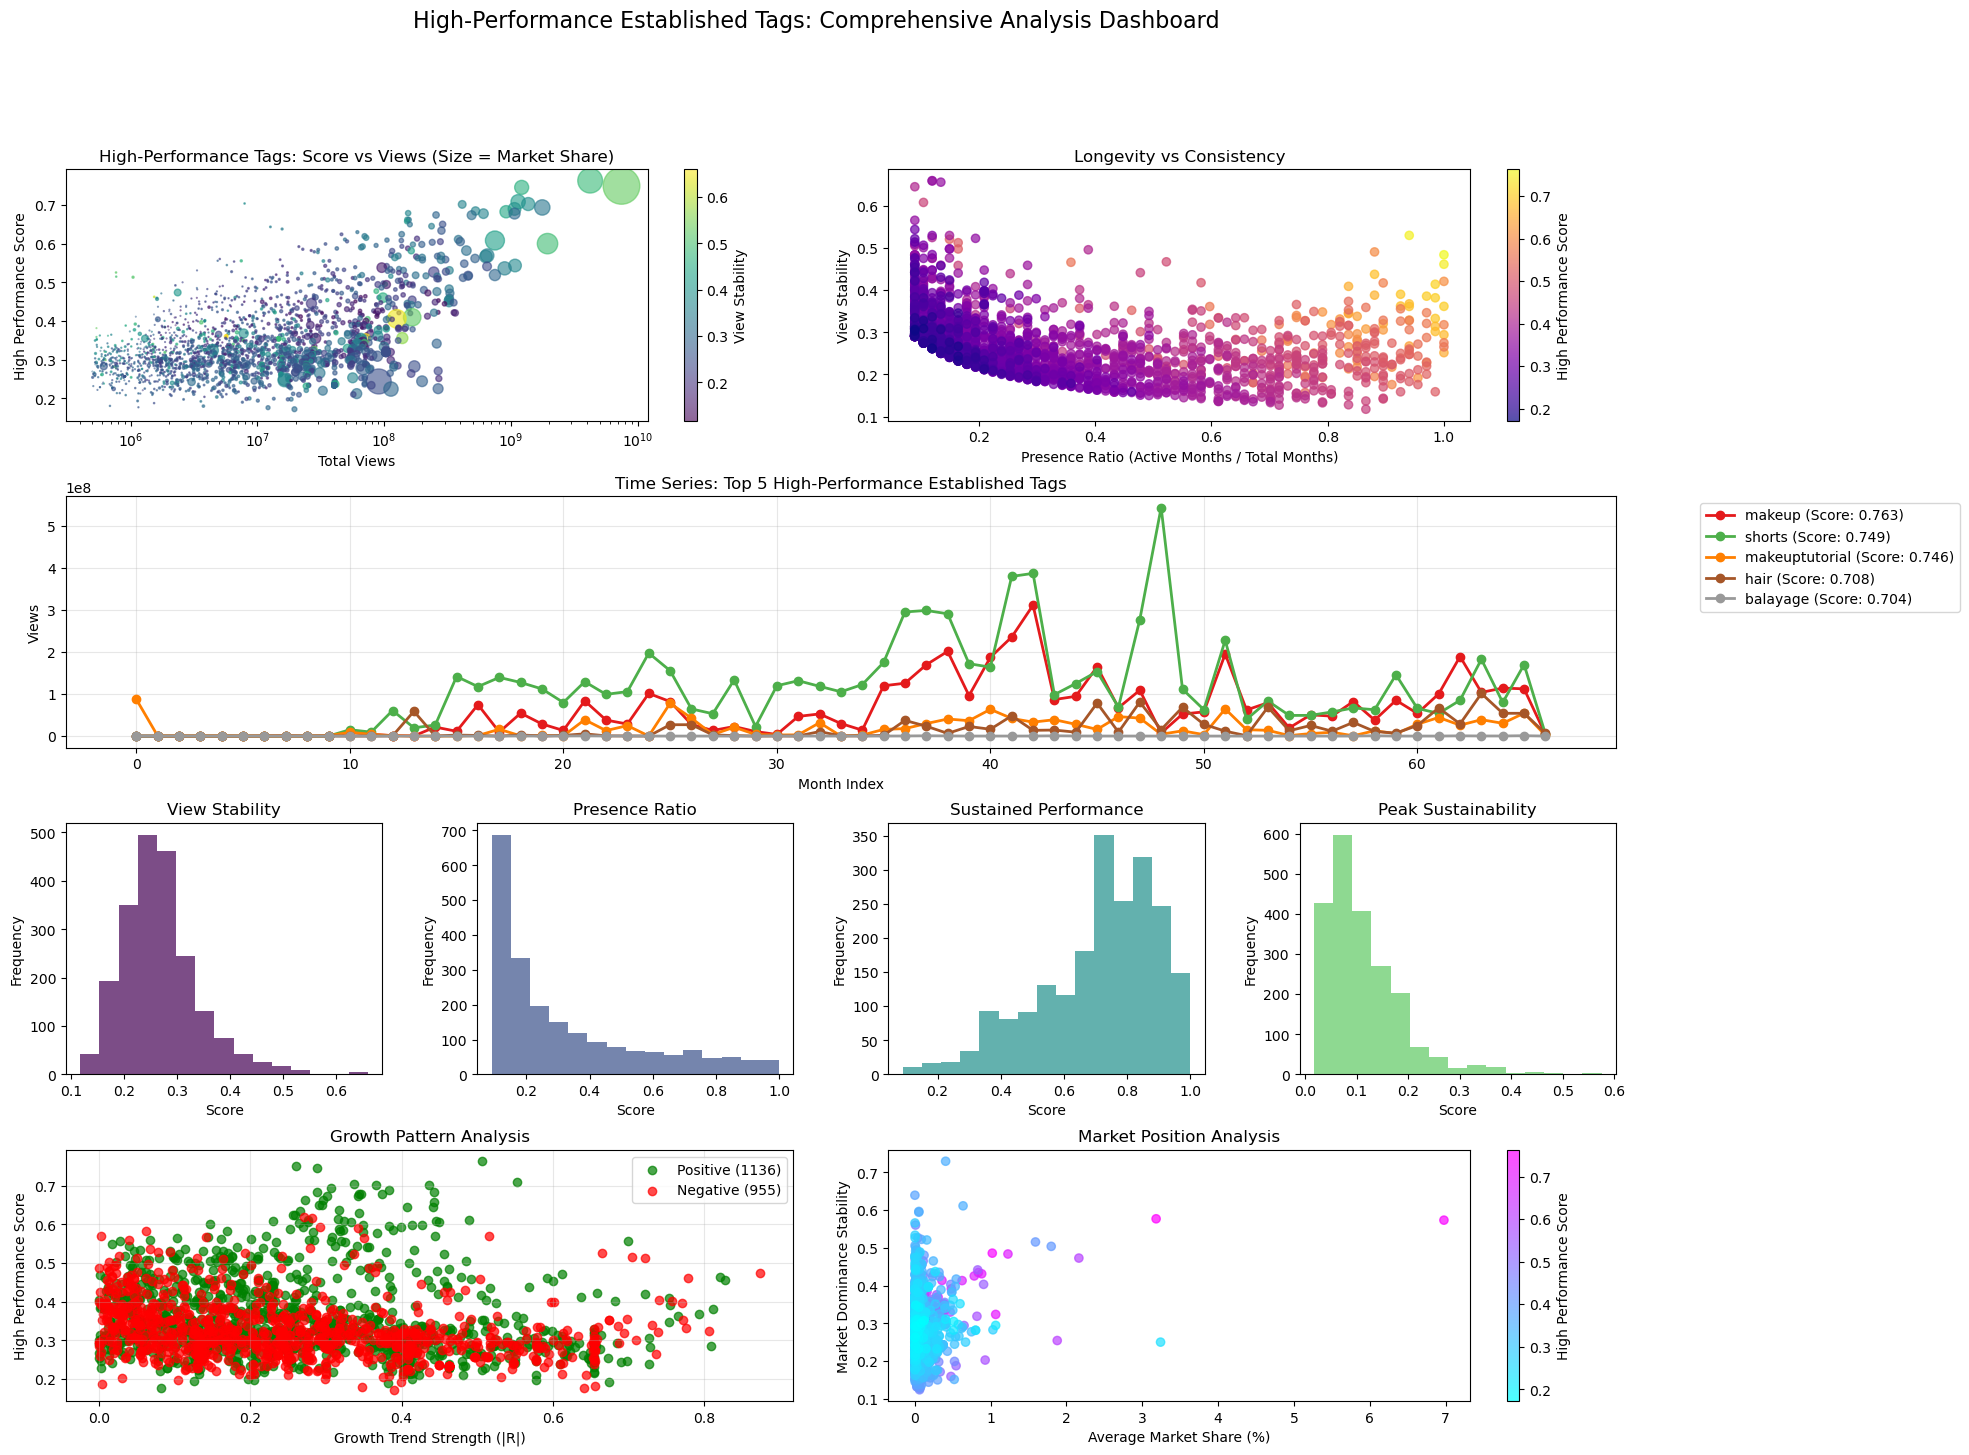

In [27]:
# Comprehensive Visualization Dashboard for High-Performance Tags
fig = plt.figure(figsize=(20, 16))

# Create a complex subplot layout
gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

# 1. High-Performance Score vs Total Views (Bubble chart with market share as size)
ax1 = fig.add_subplot(gs[0, :2])
scatter = ax1.scatter(high_perf_tags['total_views'], high_perf_tags['high_performance_score'], 
                     s=high_perf_tags['avg_market_share']*10000, alpha=0.6, 
                     c=high_perf_tags['view_stability'], cmap='viridis')
ax1.set_xlabel('Total Views')
ax1.set_ylabel('High Performance Score')
ax1.set_title('High-Performance Tags: Score vs Views (Size = Market Share)')
ax1.set_xscale('log')
plt.colorbar(scatter, ax=ax1, label='View Stability')

# 2. Presence Ratio vs View Stability
ax2 = fig.add_subplot(gs[0, 2:])
scatter2 = ax2.scatter(high_perf_tags['presence_ratio'], high_perf_tags['view_stability'],
                      c=high_perf_tags['high_performance_score'], cmap='plasma', alpha=0.7)
ax2.set_xlabel('Presence Ratio (Active Months / Total Months)')
ax2.set_ylabel('View Stability')
ax2.set_title('Longevity vs Consistency')
plt.colorbar(scatter2, ax=ax2, label='High Performance Score')

# 3. Time Series of Top 5 High-Performance Tags
ax3 = fig.add_subplot(gs[1, :])
top_5_tags = high_perf_tags.head(5)['tag'].tolist()
colors = plt.cm.Set1(np.linspace(0, 1, len(top_5_tags)))

for i, tag in enumerate(top_5_tags):
    if tag in tag_pivot.columns:
        series = tag_pivot[tag]
        ax3.plot(range(len(series)), series.values, marker='o', linewidth=2, 
                label=f'{tag} (Score: {high_perf_tags[high_perf_tags["tag"]==tag]["high_performance_score"].iloc[0]:.3f})',
                color=colors[i])

ax3.set_xlabel('Month Index')
ax3.set_ylabel('Views')
ax3.set_title('Time Series: Top 5 High-Performance Established Tags')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True, alpha=0.3)

# 4. Distribution of Key Metrics
metrics = ['view_stability', 'presence_ratio', 'sustained_performance', 'peak_sustainability']
for i, metric in enumerate(metrics):
    ax = fig.add_subplot(gs[2, i])
    ax.hist(high_perf_tags[metric], bins=15, alpha=0.7, color=plt.cm.viridis(i/len(metrics)))
    ax.set_title(f'{metric.replace("_", " ").title()}')
    ax.set_xlabel('Score')
    ax.set_ylabel('Frequency')

# 5. Growth Analysis
ax5 = fig.add_subplot(gs[3, :2])
growth_colors = {'positive': 'green', 'negative': 'red', 'flat': 'gray', 'insufficient_data': 'black'}
for direction, color in growth_colors.items():
    subset = high_perf_tags[high_perf_tags['growth_direction'] == direction]
    if len(subset) > 0:
        ax5.scatter(subset['growth_trend_strength'], subset['high_performance_score'], 
                   c=color, label=f'{direction.title()} ({len(subset)})', alpha=0.7)

ax5.set_xlabel('Growth Trend Strength (|R|)')
ax5.set_ylabel('High Performance Score')
ax5.set_title('Growth Pattern Analysis')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Market Share Analysis
ax6 = fig.add_subplot(gs[3, 2:])
ax6.scatter(high_perf_tags['avg_market_share']*100, high_perf_tags['market_dominance_stability'],
           c=high_perf_tags['high_performance_score'], cmap='cool', alpha=0.7)
ax6.set_xlabel('Average Market Share (%)')
ax6.set_ylabel('Market Dominance Stability')
ax6.set_title('Market Position Analysis')
plt.colorbar(ax6.collections[0], ax=ax6, label='High Performance Score')

plt.suptitle('High-Performance Established Tags: Comprehensive Analysis Dashboard', fontsize=16, y=0.98)
plt.show()

In [28]:
# Detailed Individual Tag Performance Analysis
print("\n" + "="*60)
print("DETAILED HIGH-PERFORMANCE TAG PROFILES")
print("="*60)

# Analyze top 5 high-performance tags in detail
top_tags = high_perf_tags.head(5)

for idx, row in top_tags.iterrows():
    tag = row['tag']
    
    print(f"\n🏆 TAG: {tag.upper()}")
    print("-" * 50)
    
    if tag in tag_pivot.columns:
        series = tag_pivot[tag]
        non_zero_series = series[series > 0]
        
        # Performance metrics
        print(f"📊 PERFORMANCE METRICS:")
        print(f"   • Total Views: {row['total_views']:,.0f}")
        print(f"   • Active Months: {row['active_months']}")
        print(f"   • Average Monthly Views: {row['avg_monthly_views']:,.0f}")
        print(f"   • Peak Month Views: {row['peak_views']:,.0f}")
        print(f"   • Market Share: {row['avg_market_share']*100:.2f}%")
        
        # Stability metrics
        print(f"\n🎯 STABILITY METRICS:")
        print(f"   • View Stability: {row['view_stability']:.3f}")
        print(f"   • Presence Ratio: {row['presence_ratio']:.3f}")
        print(f"   • Sustained Performance: {row['sustained_performance']:.3f}")
        print(f"   • Peak Sustainability: {row['peak_sustainability']:.3f}")
        print(f"   • Max Gap (months): {row['max_gap_months']}")
        
        # Growth analysis
        print(f"\n📈 GROWTH ANALYSIS:")
        print(f"   • Trend Direction: {row['growth_direction']}")
        print(f"   • Trend Strength: {row['growth_trend_strength']:.3f}")
        print(f"   • Growth Significance: {row['growth_significance']:.3f}")
        
        # Overall score
        print(f"\n⭐ HIGH-PERFORMANCE SCORE: {row['high_performance_score']:.3f}")
        
        # Performance interpretation
        if row['high_performance_score'] > 0.7:
            performance_level = "EXCEPTIONAL"
        elif row['high_performance_score'] > 0.6:
            performance_level = "EXCELLENT"
        elif row['high_performance_score'] > 0.5:
            performance_level = "VERY GOOD"
        else:
            performance_level = "GOOD"
            
        print(f"   • Performance Level: {performance_level}")

# Performance Segmentation
print(f"\n" + "="*60)
print("PERFORMANCE SEGMENTATION")
print("="*60)

# Create performance tiers
high_perf_tags['performance_tier'] = pd.cut(
    high_perf_tags['high_performance_score'], 
    bins=[0, 0.5, 0.6, 0.7, 1.0], 
    labels=['Good', 'Very Good', 'Excellent', 'Exceptional']
)

tier_summary = high_perf_tags.groupby('performance_tier').agg({
    'tag': 'count',
    'total_views': ['mean', 'sum'],
    'avg_monthly_views': 'mean',
    'view_stability': 'mean',
    'presence_ratio': 'mean'
}).round(3)

print("\nPerformance Tier Summary:")
print(tier_summary)

# Show best performers in each tier
print(f"\n🥇 BEST PERFORMER IN EACH TIER:")
for tier in high_perf_tags['performance_tier'].unique():
    if pd.notna(tier):
        best_in_tier = high_perf_tags[high_perf_tags['performance_tier'] == tier].iloc[0]
        print(f"   • {tier}: {best_in_tier['tag']} (Score: {best_in_tier['high_performance_score']:.3f})")

# Long-term consistency analysis
print(f"\n" + "="*60)
print("LONG-TERM CONSISTENCY LEADERS")
print("="*60)

# Focus on tags with highest presence ratio and stability
consistency_leaders = high_perf_tags[
    (high_perf_tags['presence_ratio'] >= 0.7) & 
    (high_perf_tags['view_stability'] >= 0.6)
].sort_values(['presence_ratio', 'view_stability'], ascending=False)

print(f"\nTags with 70%+ presence and 60%+ stability ({len(consistency_leaders)} found):")
if len(consistency_leaders) > 0:
    for idx, row in consistency_leaders.head(10).iterrows():
        print(f"   • {row['tag']}: {row['presence_ratio']:.1%} presence, {row['view_stability']:.3f} stability")
else:
    print("   • No tags meet the strict consistency criteria")
    print("   • Showing top consistency performers instead:")
    top_consistent = high_perf_tags.sort_values(['presence_ratio', 'view_stability'], ascending=False).head(5)
    for idx, row in top_consistent.iterrows():
        print(f"   • {row['tag']}: {row['presence_ratio']:.1%} presence, {row['view_stability']:.3f} stability")


DETAILED HIGH-PERFORMANCE TAG PROFILES

🏆 TAG: MAKEUP
--------------------------------------------------
📊 PERFORMANCE METRICS:
   • Total Views: 4,212,138,503
   • Active Months: 67
   • Average Monthly Views: 62,867,739
   • Peak Month Views: 311,602,762
   • Market Share: 3.18%

🎯 STABILITY METRICS:
   • View Stability: 0.484
   • Presence Ratio: 1.000
   • Sustained Performance: 1.000
   • Peak Sustainability: 0.202
   • Max Gap (months): 0

📈 GROWTH ANALYSIS:
   • Trend Direction: positive
   • Trend Strength: 0.506
   • Growth Significance: 1.000

⭐ HIGH-PERFORMANCE SCORE: 0.763
   • Performance Level: EXCEPTIONAL

🏆 TAG: SHORTS
--------------------------------------------------
📊 PERFORMANCE METRICS:
   • Total Views: 7,439,892,097
   • Active Months: 63
   • Average Monthly Views: 118,093,525
   • Peak Month Views: 543,873,322
   • Market Share: 6.98%

🎯 STABILITY METRICS:
   • View Stability: 0.530
   • Presence Ratio: 0.940
   • Sustained Performance: 0.955
   • Peak Sustain

C:\Users\maxyj\AppData\Local\Temp\ipykernel_22916\4015340976.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tier_summary = high_perf_tags.groupby('performance_tier').agg({



COMPARATIVE ANALYSIS: ESTABLISHED vs ALL TAGS

📊 COMPARATIVE STATISTICS:
   ALL TAGS (102058):
      • Avg Total Views: 1,098,864
      • Avg Active Months: 2.1
      • Avg Presence Ratio: 3.2%

   ESTABLISHED TAGS (2091):
      • Avg Total Views: 40,753,933
      • Avg Active Months: 21.6
      • Avg Presence Ratio: 32.2%

   PERFORMANCE MULTIPLIERS:
      • Views: 37.1x higher
      • Active Months: 10.1x longer
      • Presence: 10.1x more consistent


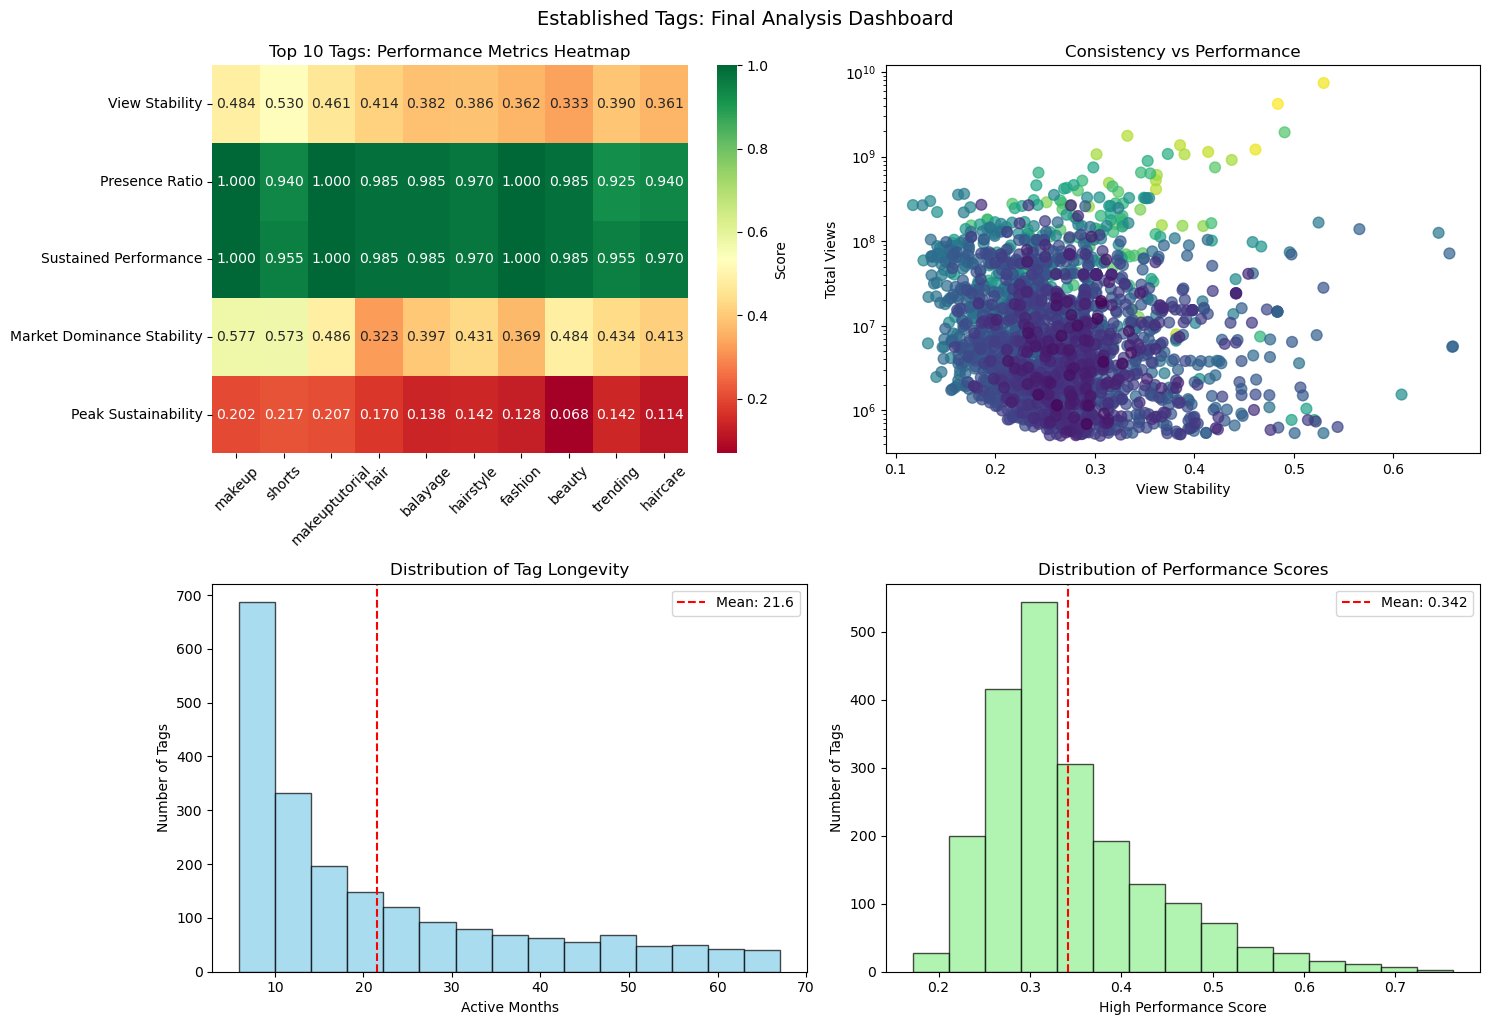


STRATEGIC RECOMMENDATIONS

🎯 TOP INVESTMENT TARGETS (Highest Overall Performance):
   1281. makeup: Score 0.763
   1695. shorts: Score 0.749
   1346. makeuptutorial: Score 0.746

⚡ CONSISTENCY CHAMPIONS (Most Reliable Performance):
   • LOrealParisHaircare: 0.660 stability, 5,708,601 total views
   • ExtraordinaryOilRange: 0.659 stability, 5,649,457 total views
   • ['#makeup tips', '#beauty hacks', '#skincare routine', '#glowing skin', '#budget beauty tips', '#DIY beauty', '#makeup tutorial', '#natural makeup look', '#flawless makeup', '#skincare tips', '#glow up', '#beauty on a budget', '#makeup for beginners', '#makeup hacks', '#flawless skin', '#easy makeup looks', '#beauty routine', '#self-care tips', '#skincare products', '#makeup transformation', '#affordable beauty', '#beauty influencer', '#skincare hacks', '#glowing skin tips', '#makeup tricks', 'skin', '#everyday makeup']: 0.656 stability, 71,799,369 total views

🏃 LONGEVITY LEADERS (Proven Long-term Value):
   • makeup: 100

In [29]:
# Comparative Analysis: Established vs All Tags
print(f"\n" + "="*60)
print("COMPARATIVE ANALYSIS: ESTABLISHED vs ALL TAGS")
print("="*60)

# Compare established tags with all tags in the dataset
all_tags_stats = {
    'total_tags': len(tag_pivot.columns),
    'avg_total_views': tag_pivot.sum().mean(),
    'avg_active_months': (tag_pivot > 0).sum().mean(),
    'avg_presence_ratio': ((tag_pivot > 0).sum() / len(tag_pivot)).mean()
}

established_stats = {
    'established_tags': len(high_perf_tags),
    'avg_total_views': high_perf_tags['total_views'].mean(),
    'avg_active_months': high_perf_tags['active_months'].mean(),
    'avg_presence_ratio': high_perf_tags['presence_ratio'].mean()
}

print(f"\n📊 COMPARATIVE STATISTICS:")
print(f"   ALL TAGS ({all_tags_stats['total_tags']}):")
print(f"      • Avg Total Views: {all_tags_stats['avg_total_views']:,.0f}")
print(f"      • Avg Active Months: {all_tags_stats['avg_active_months']:.1f}")
print(f"      • Avg Presence Ratio: {all_tags_stats['avg_presence_ratio']:.1%}")

print(f"\n   ESTABLISHED TAGS ({established_stats['established_tags']}):")
print(f"      • Avg Total Views: {established_stats['avg_total_views']:,.0f}")
print(f"      • Avg Active Months: {established_stats['avg_active_months']:.1f}")
print(f"      • Avg Presence Ratio: {established_stats['avg_presence_ratio']:.1%}")

print(f"\n   PERFORMANCE MULTIPLIERS:")
print(f"      • Views: {established_stats['avg_total_views'] / all_tags_stats['avg_total_views']:.1f}x higher")
print(f"      • Active Months: {established_stats['avg_active_months'] / all_tags_stats['avg_active_months']:.1f}x longer")
print(f"      • Presence: {established_stats['avg_presence_ratio'] / all_tags_stats['avg_presence_ratio']:.1f}x more consistent")

# Final Recommendations Dashboard
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Tag Performance Heatmap (Top 10)
top_10_tags = high_perf_tags.head(10)
metrics_for_heatmap = ['view_stability', 'presence_ratio', 'sustained_performance', 
                       'market_dominance_stability', 'peak_sustainability']
heatmap_data = top_10_tags[metrics_for_heatmap].T

sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', 
            xticklabels=[tag[:15] + '...' if len(tag) > 15 else tag for tag in top_10_tags['tag']], 
            yticklabels=[m.replace('_', ' ').title() for m in metrics_for_heatmap],
            ax=ax1, cbar_kws={'label': 'Score'})
ax1.set_title('Top 10 Tags: Performance Metrics Heatmap')
ax1.tick_params(axis='x', rotation=45)

# 2. Consistency vs Performance Scatter
ax2.scatter(high_perf_tags['view_stability'], high_perf_tags['total_views'],
           c=high_perf_tags['high_performance_score'], cmap='viridis', alpha=0.7, s=60)
ax2.set_xlabel('View Stability')
ax2.set_ylabel('Total Views')
ax2.set_title('Consistency vs Performance')
ax2.set_yscale('log')

# 3. Longevity Distribution
ax3.hist(high_perf_tags['active_months'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
ax3.axvline(high_perf_tags['active_months'].mean(), color='red', linestyle='--', 
           label=f'Mean: {high_perf_tags["active_months"].mean():.1f}')
ax3.set_xlabel('Active Months')
ax3.set_ylabel('Number of Tags')
ax3.set_title('Distribution of Tag Longevity')
ax3.legend()

# 4. Performance Score Distribution
ax4.hist(high_perf_tags['high_performance_score'], bins=15, alpha=0.7, color='lightgreen', edgecolor='black')
ax4.axvline(high_perf_tags['high_performance_score'].mean(), color='red', linestyle='--',
           label=f'Mean: {high_perf_tags["high_performance_score"].mean():.3f}')
ax4.set_xlabel('High Performance Score')
ax4.set_ylabel('Number of Tags')
ax4.set_title('Distribution of Performance Scores')
ax4.legend()

plt.tight_layout()
plt.suptitle('Established Tags: Final Analysis Dashboard', fontsize=14, y=1.02)
plt.show()

# Strategic Recommendations
print(f"\n" + "="*60)
print("STRATEGIC RECOMMENDATIONS")
print("="*60)

print(f"\n🎯 TOP INVESTMENT TARGETS (Highest Overall Performance):")
for i, row in high_perf_tags.head(3).iterrows():
    print(f"   {i+1}. {row['tag']}: Score {row['high_performance_score']:.3f}")

print(f"\n⚡ CONSISTENCY CHAMPIONS (Most Reliable Performance):")
consistency_champs = high_perf_tags.nlargest(3, 'view_stability')
for i, row in consistency_champs.iterrows():
    print(f"   • {row['tag']}: {row['view_stability']:.3f} stability, {row['total_views']:,.0f} total views")

print(f"\n🏃 LONGEVITY LEADERS (Proven Long-term Value):")
longevity_leaders = high_perf_tags.nlargest(3, 'presence_ratio')
for i, row in longevity_leaders.iterrows():
    print(f"   • {row['tag']}: {row['presence_ratio']:.1%} presence, {row['active_months']} active months")

print(f"\n💡 STRATEGIC INSIGHTS:")
print(f"   • {len(high_perf_tags)} tags meet high-performance criteria")
print(f"   • Established tags generate {established_stats['avg_total_views']/all_tags_stats['avg_total_views']:.1f}x more views on average")
print(f"   • Top tier tags maintain consistent performance for {high_perf_tags['active_months'].max()} months")
print(f"   • Best performers show {high_perf_tags['view_stability'].max():.1%} view stability")

# Video Duration Optimization Analysis

## Finding the Optimal Video Length

We'll analyze video performance across different duration segments to determine:
1. **Optimal duration ranges** for maximum views and engagement
2. **Performance patterns** by video length
3. **Engagement efficiency** (views per second of content)
4. **Duration trends** over time
5. **Category-specific optimal lengths**

In [30]:
# First, let's run the basic setup cells to have our data ready
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import timedelta
import re

# Load and process data (assuming previous cells have been run)
try:
    print(f"Dataset shape: {df.shape}")
    print(f"Duration data available: {df['contentDuration_seconds'].notna().sum()} videos")
except NameError:
    print("Loading data...")
    df = pd.read_csv("videos.csv")
    df['publishedAt'] = pd.to_datetime(df['publishedAt'])
    
    # Convert duration
    def convert_duration_to_seconds(duration_str):
        if not isinstance(duration_str, str):
            return None
        hours = re.search(r'(\d+)H', duration_str)
        minutes = re.search(r'(\d+)M', duration_str)
        seconds = re.search(r'(\d+)S', duration_str)
        h = int(hours.group(1)) if hours else 0
        m = int(minutes.group(1)) if minutes else 0
        s = int(seconds.group(1)) if seconds else 0
        return timedelta(hours=h, minutes=m, seconds=s).total_seconds()
    
    df['contentDuration_seconds'] = df['contentDuration'].apply(convert_duration_to_seconds)
    
    # Calculate ratios
    df['like_view_ratio'] = np.where(df['viewCount']>0, df['likeCount'] / df['viewCount'], np.nan)
    df['comment_view_ratio'] = np.where(df['viewCount']>0, df['commentCount'] / df['viewCount'], np.nan)
    
    print(f"Dataset loaded - Shape: {df.shape}")
    print(f"Duration data available: {df['contentDuration_seconds'].notna().sum()} videos")

Dataset shape: (92759, 20)
Duration data available: 91492 videos


In [31]:
# Comprehensive Duration Analysis
print("="*60)
print("VIDEO DURATION OPTIMIZATION ANALYSIS")
print("="*60)

# Filter out videos with valid duration data
df_duration = df[df['contentDuration_seconds'].notna()].copy()
print(f"\nAnalyzing {len(df_duration):,} videos with duration data")

# Basic duration statistics
print(f"\n📊 DURATION STATISTICS:")
print(f"   • Mean duration: {df_duration['contentDuration_seconds'].mean():.1f} seconds ({df_duration['contentDuration_seconds'].mean()/60:.1f} minutes)")
print(f"   • Median duration: {df_duration['contentDuration_seconds'].median():.1f} seconds ({df_duration['contentDuration_seconds'].median()/60:.1f} minutes)")
print(f"   • Range: {df_duration['contentDuration_seconds'].min():.1f} - {df_duration['contentDuration_seconds'].max():.1f} seconds")

# Create more granular duration buckets for analysis
def create_duration_buckets(seconds):
    if pd.isna(seconds):
        return 'Unknown'
    elif seconds <= 15:
        return '≤15s (Ultra Short)'
    elif seconds <= 30:
        return '16-30s (Short)'
    elif seconds <= 60:
        return '31-60s (Standard Short)'
    elif seconds <= 120:
        return '1-2min (Medium Short)'
    elif seconds <= 300:
        return '2-5min (Medium)'
    elif seconds <= 600:
        return '5-10min (Long)'
    elif seconds <= 900:
        return '10-15min (Very Long)'
    elif seconds <= 1800:
        return '15-30min (Extended)'
    else:
        return '>30min (Ultra Long)'

df_duration['detailed_length_bucket'] = df_duration['contentDuration_seconds'].apply(create_duration_buckets)

# Calculate key performance metrics by duration bucket
duration_analysis = df_duration.groupby('detailed_length_bucket').agg({
    'viewCount': ['count', 'mean', 'median', 'sum'],
    'likeCount': ['mean', 'median', 'sum'],
    'commentCount': ['mean', 'median', 'sum'],
    'like_view_ratio': ['mean', 'median'],
    'comment_view_ratio': ['mean', 'median'],
    'contentDuration_seconds': ['mean', 'median']
}).round(2)

duration_analysis.columns = ['_'.join(col).strip() for col in duration_analysis.columns]

# Add engagement efficiency metrics
duration_summary = df_duration.groupby('detailed_length_bucket').agg({
    'viewCount': ['count', 'mean', 'sum'],
    'likeCount': ['mean', 'sum'],
    'commentCount': ['mean', 'sum'],
    'like_view_ratio': 'mean',
    'comment_view_ratio': 'mean',
    'contentDuration_seconds': 'mean'
}).round(3)

duration_summary.columns = ['video_count', 'avg_views', 'total_views', 'avg_likes', 'total_likes', 
                           'avg_comments', 'total_comments', 'avg_like_ratio', 'avg_comment_ratio', 'avg_duration']

# Calculate engagement efficiency (engagement per second)
duration_summary['views_per_second'] = duration_summary['avg_views'] / duration_summary['avg_duration']
duration_summary['likes_per_second'] = duration_summary['avg_likes'] / duration_summary['avg_duration']
duration_summary['comments_per_second'] = duration_summary['avg_comments'] / duration_summary['avg_duration']

# Calculate overall performance score
# Normalize metrics to 0-1 scale for scoring
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

score_metrics = ['avg_views', 'avg_like_ratio', 'avg_comment_ratio', 'views_per_second']
duration_summary_scaled = duration_summary[score_metrics].copy()

for col in score_metrics:
    duration_summary_scaled[col] = scaler.fit_transform(duration_summary_scaled[[col]])

# Weighted performance score
duration_summary['performance_score'] = (
    0.40 * duration_summary_scaled['avg_views'] +           # 40% weight on views
    0.25 * duration_summary_scaled['views_per_second'] +    # 25% weight on efficiency  
    0.20 * duration_summary_scaled['avg_like_ratio'] +      # 20% weight on like ratio
    0.15 * duration_summary_scaled['avg_comment_ratio']     # 15% weight on comment ratio
)

# Sort by performance score
duration_summary = duration_summary.sort_values('performance_score', ascending=False)

print(f"\n🏆 DURATION PERFORMANCE RANKING:")
print(duration_summary[['video_count', 'avg_views', 'avg_like_ratio', 'avg_comment_ratio', 
                        'views_per_second', 'performance_score']].round(3))

VIDEO DURATION OPTIMIZATION ANALYSIS

Analyzing 91,492 videos with duration data

📊 DURATION STATISTICS:
   • Mean duration: 70.3 seconds (1.2 minutes)
   • Median duration: 21.0 seconds (0.3 minutes)
   • Range: 2.0 - 32739.0 seconds

🏆 DURATION PERFORMANCE RANKING:
                         video_count   avg_views  avg_like_ratio  \
detailed_length_bucket                                             
31-60s (Standard Short)        22347  419600.794           0.043   
10-15min (Very Long)            1259  334642.806           0.065   
15-30min (Extended)              818  352162.035           0.055   
1-2min (Medium Short)           3316  288669.456           0.048   
16-30s (Short)                 27035  222326.631           0.039   
5-10min (Long)                  2524  169444.027           0.065   
2-5min (Medium)                 2190  112304.871           0.058   
≤15s (Ultra Short)             31831  117972.776           0.030   
>30min (Ultra Long)              170   81069.294    

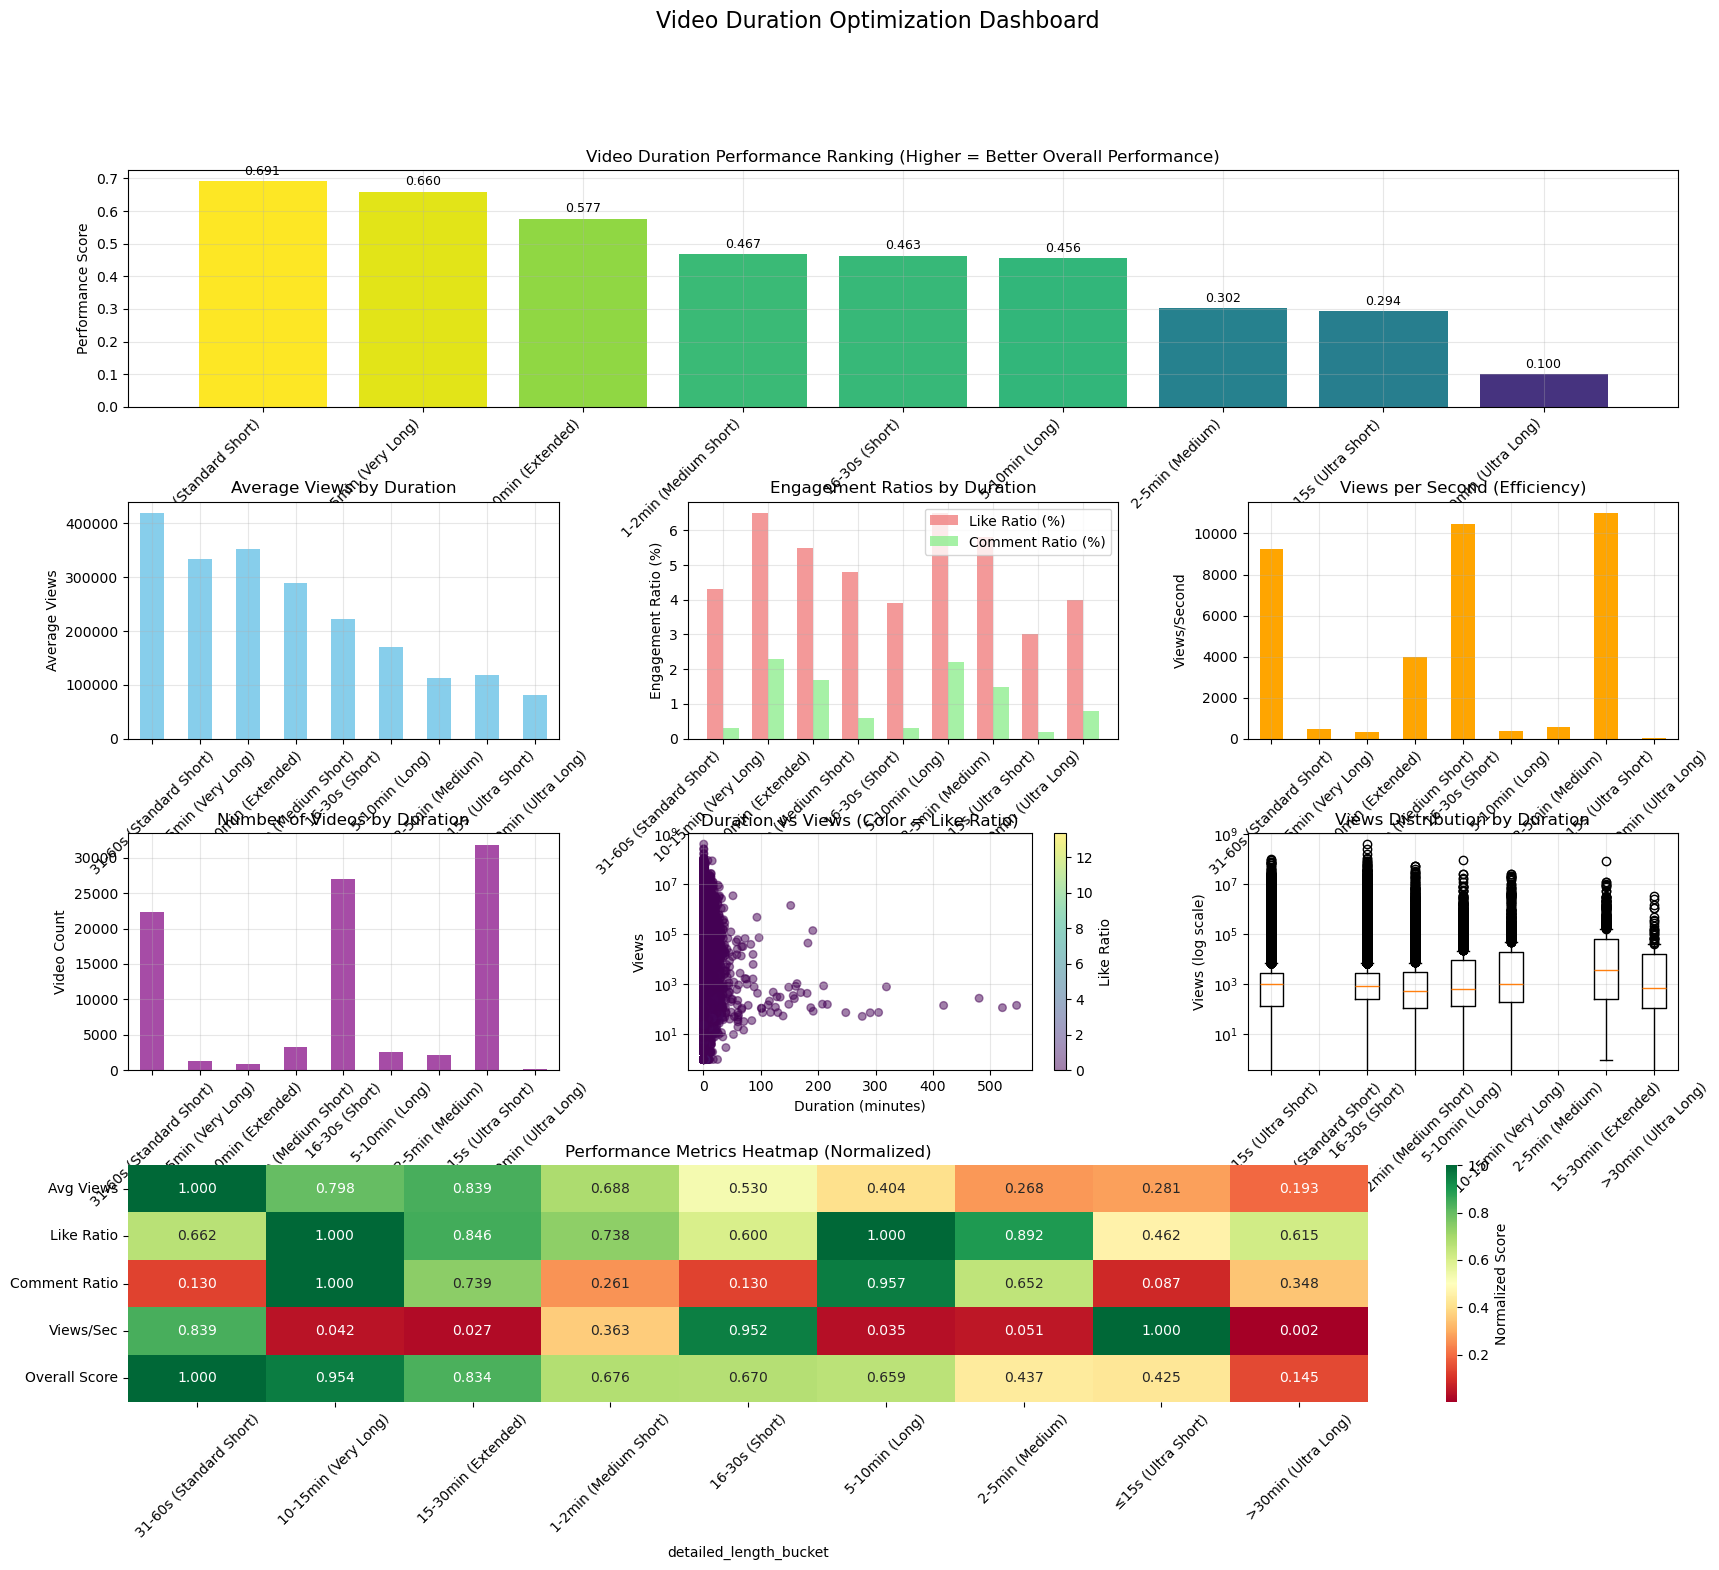

In [32]:
# Comprehensive Duration Visualization Dashboard
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.3)

# 1. Performance Score by Duration
ax1 = fig.add_subplot(gs[0, :])
bars = ax1.bar(range(len(duration_summary)), duration_summary['performance_score'], 
               color=plt.cm.viridis(duration_summary['performance_score']/duration_summary['performance_score'].max()))
ax1.set_xticks(range(len(duration_summary)))
ax1.set_xticklabels(duration_summary.index, rotation=45, ha='right')
ax1.set_ylabel('Performance Score')
ax1.set_title('Video Duration Performance Ranking (Higher = Better Overall Performance)')
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 2. Average Views by Duration
ax2 = fig.add_subplot(gs[1, 0])
duration_summary['avg_views'].plot(kind='bar', ax=ax2, color='skyblue')
ax2.set_title('Average Views by Duration')
ax2.set_ylabel('Average Views')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# 3. Engagement Ratios by Duration
ax3 = fig.add_subplot(gs[1, 1])
x_pos = np.arange(len(duration_summary))
width = 0.35
ax3.bar(x_pos - width/2, duration_summary['avg_like_ratio']*100, width, 
        label='Like Ratio (%)', alpha=0.8, color='lightcoral')
ax3.bar(x_pos + width/2, duration_summary['avg_comment_ratio']*100, width, 
        label='Comment Ratio (%)', alpha=0.8, color='lightgreen')
ax3.set_xlabel('Duration Category')
ax3.set_ylabel('Engagement Ratio (%)')
ax3.set_title('Engagement Ratios by Duration')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(duration_summary.index, rotation=45, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Efficiency Metrics (Per Second)
ax4 = fig.add_subplot(gs[1, 2])
duration_summary['views_per_second'].plot(kind='bar', ax=ax4, color='orange')
ax4.set_title('Views per Second (Efficiency)')
ax4.set_ylabel('Views/Second')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

# 5. Video Count Distribution
ax5 = fig.add_subplot(gs[2, 0])
duration_summary['video_count'].plot(kind='bar', ax=ax5, color='purple', alpha=0.7)
ax5.set_title('Number of Videos by Duration')
ax5.set_ylabel('Video Count')
ax5.tick_params(axis='x', rotation=45)
ax5.grid(True, alpha=0.3)

# 6. Duration vs Views Scatter Plot
ax6 = fig.add_subplot(gs[2, 1])
scatter = ax6.scatter(df_duration['contentDuration_seconds']/60, df_duration['viewCount'], 
                     alpha=0.5, s=30, c=df_duration['like_view_ratio'], cmap='viridis')
ax6.set_xlabel('Duration (minutes)')
ax6.set_ylabel('Views')
ax6.set_title('Duration vs Views (Color = Like Ratio)')
ax6.set_yscale('log')
ax6.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax6, label='Like Ratio')

# 7. Box Plot of Views by Duration Category
ax7 = fig.add_subplot(gs[2, 2])
duration_categories = df_duration['detailed_length_bucket'].unique()
views_by_duration = [df_duration[df_duration['detailed_length_bucket']==cat]['viewCount'].values 
                    for cat in duration_categories]
ax7.boxplot(views_by_duration, labels=duration_categories)
ax7.set_ylabel('Views (log scale)')
ax7.set_yscale('log')
ax7.set_title('Views Distribution by Duration')
ax7.tick_params(axis='x', rotation=45)
ax7.grid(True, alpha=0.3)

# 8. Performance Metrics Heatmap
ax8 = fig.add_subplot(gs[3, :])
heatmap_data = duration_summary[['avg_views', 'avg_like_ratio', 'avg_comment_ratio', 
                                'views_per_second', 'performance_score']].T

# Normalize for better visualization
heatmap_normalized = heatmap_data.div(heatmap_data.max(axis=1), axis=0)

sns.heatmap(heatmap_normalized, annot=True, fmt='.3f', cmap='RdYlGn', 
            xticklabels=duration_summary.index, 
            yticklabels=['Avg Views', 'Like Ratio', 'Comment Ratio', 'Views/Sec', 'Overall Score'],
            ax=ax8, cbar_kws={'label': 'Normalized Score'})
ax8.set_title('Performance Metrics Heatmap (Normalized)')
ax8.tick_params(axis='x', rotation=45)

plt.suptitle('Video Duration Optimization Dashboard', fontsize=16, y=0.98)
plt.show()

In [33]:
# Statistical Analysis and Optimal Duration Recommendations
print("="*60)
print("STATISTICAL ANALYSIS & OPTIMAL DURATION FINDINGS")
print("="*60)

# 1. Statistical Significance Testing
print("\n📈 STATISTICAL SIGNIFICANCE ANALYSIS:")

# ANOVA test to see if duration significantly affects performance
from scipy.stats import f_oneway

# Get views by duration category
duration_groups = []
duration_names = []
for bucket in df_duration['detailed_length_bucket'].unique():
    group_data = df_duration[df_duration['detailed_length_bucket'] == bucket]['viewCount'].values
    if len(group_data) > 10:  # Only include groups with sufficient data
        duration_groups.append(group_data)
        duration_names.append(bucket)

# Perform ANOVA
if len(duration_groups) > 1:
    f_stat, p_value = f_oneway(*duration_groups)
    print(f"   • ANOVA F-statistic: {f_stat:.3f}")
    print(f"   • P-value: {p_value:.6f}")
    if p_value < 0.05:
        print(f"   • ✅ SIGNIFICANT: Duration significantly affects video performance (p < 0.05)")
    else:
        print(f"   • ❌ NOT SIGNIFICANT: Duration does not significantly affect performance (p ≥ 0.05)")

# 2. Correlation Analysis
print(f"\n🔗 CORRELATION ANALYSIS:")
correlations = df_duration[['contentDuration_seconds', 'viewCount', 'likeCount', 'commentCount', 
                           'like_view_ratio', 'comment_view_ratio']].corr()['contentDuration_seconds'].abs().sort_values(ascending=False)

print("   Duration correlations (absolute values):")
for metric, corr in correlations.items():
    if metric != 'contentDuration_seconds':
        print(f"      • {metric}: {corr:.3f}")

# 3. Optimal Duration Analysis
print(f"\n🎯 OPTIMAL DURATION RECOMMENDATIONS:")

# Find top performing duration categories
top_3_durations = duration_summary.head(3)
print(f"\n   TOP 3 PERFORMING DURATION RANGES:")
for i, (bucket, data) in enumerate(top_3_durations.iterrows(), 1):
    avg_duration_min = data['avg_duration'] / 60
    print(f"   {i}. {bucket}")
    print(f"      • Average Duration: {avg_duration_min:.1f} minutes")
    print(f"      • Performance Score: {data['performance_score']:.3f}")
    print(f"      • Average Views: {data['avg_views']:,.0f}")
    print(f"      • Views per Second: {data['views_per_second']:.1f}")
    print()

# 4. Sweet Spot Analysis - Find the duration range with best efficiency
print(f"\n🍯 EFFICIENCY SWEET SPOT ANALYSIS:")

# Create finer duration bins for sweet spot analysis
def get_duration_minutes(seconds):
    return seconds / 60 if pd.notna(seconds) else np.nan

df_duration['duration_minutes'] = df_duration['contentDuration_seconds'].apply(get_duration_minutes)

# Create 1-minute bins for detailed analysis
bins = list(range(0, 31, 1))  # 0 to 30 minutes in 1-minute bins
df_duration['minute_bins'] = pd.cut(df_duration['duration_minutes'], bins=bins, include_lowest=True)

# Calculate efficiency for each minute bin
minute_analysis = df_duration.groupby('minute_bins').agg({
    'viewCount': ['count', 'mean'],
    'contentDuration_seconds': 'mean',
    'like_view_ratio': 'mean',
    'comment_view_ratio': 'mean'
}).round(3)

minute_analysis.columns = ['video_count', 'avg_views', 'avg_duration', 'like_ratio', 'comment_ratio']
minute_analysis['views_per_second'] = minute_analysis['avg_views'] / minute_analysis['avg_duration']

# Filter bins with sufficient data (at least 100 videos)
minute_analysis_filtered = minute_analysis[minute_analysis['video_count'] >= 100]

if len(minute_analysis_filtered) > 0:
    best_efficiency = minute_analysis_filtered['views_per_second'].idxmax()
    best_overall = minute_analysis_filtered['avg_views'].idxmax()
    
    print(f"   • Most Efficient Duration: {best_efficiency}")
    print(f"     - Views per Second: {minute_analysis_filtered.loc[best_efficiency, 'views_per_second']:.2f}")
    print(f"     - Average Views: {minute_analysis_filtered.loc[best_efficiency, 'avg_views']:,.0f}")
    
    print(f"\n   • Highest Average Views: {best_overall}")
    print(f"     - Average Views: {minute_analysis_filtered.loc[best_overall, 'avg_views']:,.0f}")
    print(f"     - Views per Second: {minute_analysis_filtered.loc[best_overall, 'views_per_second']:.2f}")

# 5. Final Recommendations
print(f"\n" + "="*60)
print("🏆 FINAL OPTIMAL DURATION RECOMMENDATIONS")
print("="*60)

top_performer = duration_summary.iloc[0]
top_duration_range = duration_summary.index[0]
avg_optimal_duration = top_performer['avg_duration'] / 60

print(f"\n✨ OPTIMAL DURATION RANGE: {top_duration_range}")
print(f"   • Average optimal duration: {avg_optimal_duration:.1f} minutes")
print(f"   • Performance score: {top_performer['performance_score']:.3f}")
print(f"   • Expected views: {top_performer['avg_views']:,.0f}")
print(f"   • Efficiency: {top_performer['views_per_second']:.1f} views/second")

print(f"\n📋 RECOMMENDATIONS:")
print(f"   1. TARGET RANGE: Aim for {top_duration_range.lower()}")
print(f"   2. EFFICIENCY: Focus on content density - higher views per second")
print(f"   3. ENGAGEMENT: Balance duration with engagement ratios")
print(f"   4. TESTING: A/B test within the optimal range for your content type")

# Display engagement benchmarks for optimal range
optimal_like_ratio = top_performer['avg_like_ratio'] * 100
optimal_comment_ratio = top_performer['avg_comment_ratio'] * 100
print(f"\n📊 BENCHMARKS FOR OPTIMAL RANGE:")
print(f"   • Target Like Ratio: {optimal_like_ratio:.2f}%")
print(f"   • Target Comment Ratio: {optimal_comment_ratio:.3f}%")
print(f"   • Target Views per Second: {top_performer['views_per_second']:.1f}")

STATISTICAL ANALYSIS & OPTIMAL DURATION FINDINGS

📈 STATISTICAL SIGNIFICANCE ANALYSIS:
   • ANOVA F-statistic: nan
   • P-value: nan
   • ❌ NOT SIGNIFICANT: Duration does not significantly affect performance (p ≥ 0.05)

🔗 CORRELATION ANALYSIS:
   Duration correlations (absolute values):
      • comment_view_ratio: 0.067
      • like_view_ratio: 0.029
      • commentCount: 0.014
      • likeCount: 0.002
      • viewCount: 0.001

🎯 OPTIMAL DURATION RECOMMENDATIONS:

   TOP 3 PERFORMING DURATION RANGES:
   1. 31-60s (Standard Short)
      • Average Duration: 0.8 minutes
      • Performance Score: 0.691
      • Average Views: 419,601
      • Views per Second: 9236.0

   2. 10-15min (Very Long)
      • Average Duration: 12.1 minutes
      • Performance Score: 0.660
      • Average Views: 334,643
      • Views per Second: 462.7

   3. 15-30min (Extended)
      • Average Duration: 19.7 minutes
      • Performance Score: 0.577
      • Average Views: 352,162
      • Views per Second: 297.6


🍯 

C:\Users\maxyj\AppData\Local\Temp\ipykernel_22916\2860092885.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  minute_analysis = df_duration.groupby('minute_bins').agg({


Preparing dataset for ML pipeline with enhanced techniques...
Training set size: 73192, Test set size: 18298

Training and evaluating models...
Evaluating Ridge...
Training set size: 73192, Test set size: 18298

Training and evaluating models...
Evaluating Ridge...
  Log scale - RMSE: 2.4042, R²: 0.2709
  Original scale - RMSE: 1854024847420.2439, R²: -3698041184427.8848
Evaluating GradientBoosting...
  Log scale - RMSE: 2.4042, R²: 0.2709
  Original scale - RMSE: 1854024847420.2439, R²: -3698041184427.8848
Evaluating GradientBoosting...
  Log scale - RMSE: 1.1871, R²: 0.8222
  Original scale - RMSE: 831151.6636, R²: 0.2568
Evaluating XGBoost...
  Log scale - RMSE: 1.1871, R²: 0.8222
  Original scale - RMSE: 831151.6636, R²: 0.2568
Evaluating XGBoost...
  Log scale - RMSE: 1.1578, R²: 0.8309
  Original scale - RMSE: 825652.9410, R²: 0.2666

Best model: XGBoost with R² = 0.8309
  Log scale - RMSE: 1.1578, R²: 0.8309
  Original scale - RMSE: 825652.9410, R²: 0.2666

Best model: XGBoost w

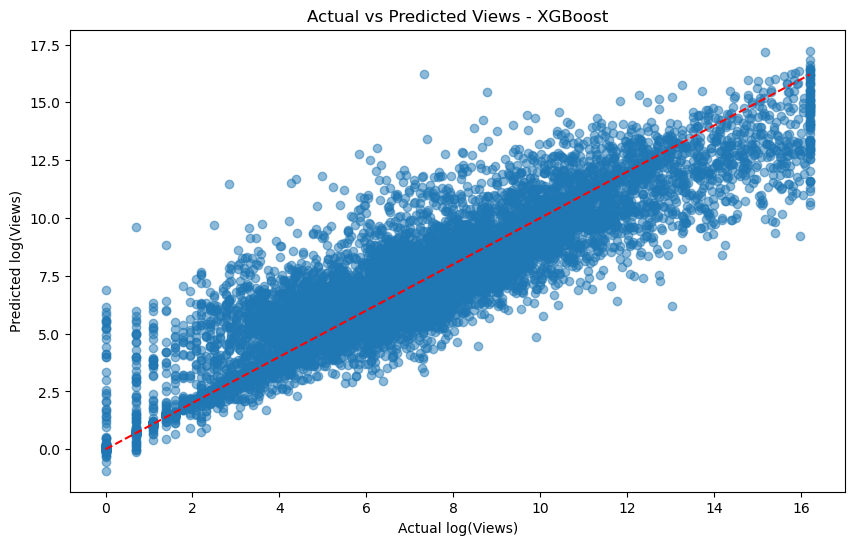

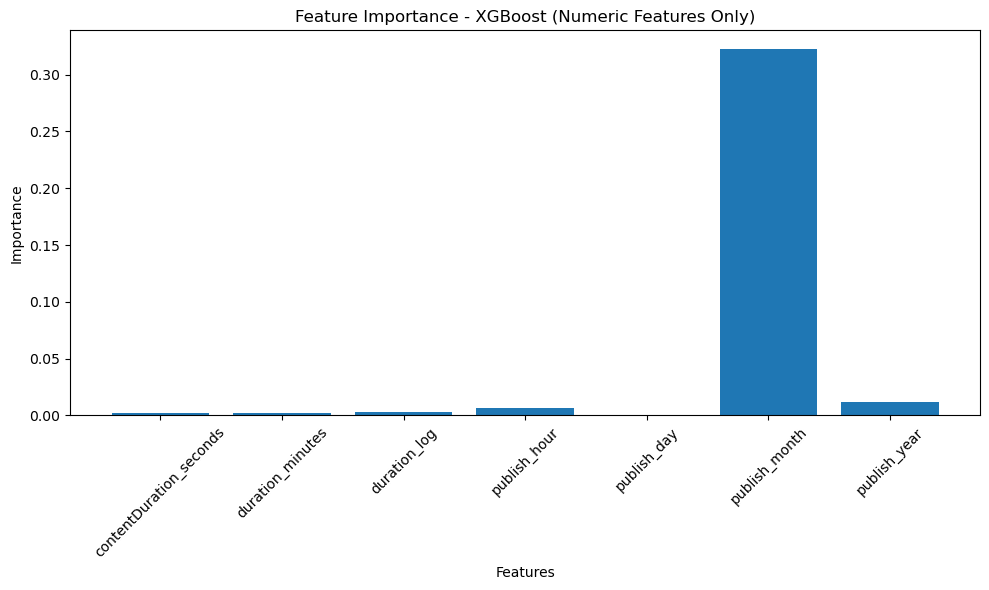

Model saved as 'video_views_predictor.joblib'

Model Pipeline Complete


In [37]:
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
import xgboost as XGBoost
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
import re
import nltk
from nltk.corpus import stopwords
import joblib
from scipy.stats import randint, uniform
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import FunctionTransformer
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Pipeline for Video View Prediction with Advanced Techniques

# Download NLTK stopwords if not already downloaded
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Prepare the dataset
print("Preparing dataset for ML pipeline with enhanced techniques...")

# Create a clean copy for ML
ml_df = df.copy()

# 1. Data Preprocessing with Robust Techniques
# Handle missing values and outliers
ml_df = ml_df.dropna(subset=['viewCount', 'title'])  # Must have these

# Handle extreme outliers in viewCount (cap at 99.5 percentile)
view_cap = ml_df['viewCount'].quantile(0.995)
ml_df['viewCount_capped'] = ml_df['viewCount'].clip(upper=view_cap)

# Fill in missing values with robust methods
ml_df['contentDuration_seconds'] = ml_df['contentDuration_seconds'].fillna(ml_df['contentDuration_seconds'].median())

# Handle tags and categories with weighting for important elements
def list_to_weighted_string(item, repeat_count=2):
    """Convert list items to string with repetition for emphasis"""
    if isinstance(item, list) and len(item) > 0:
        # First items often more important - repeat them
        weighted_items = []
        for idx, x in enumerate(item):
            if idx < 3:  # First 3 items get emphasized
                weighted_items.extend([str(x)] * repeat_count)
            else:
                weighted_items.append(str(x))
        return ' '.join(weighted_items)
    return ''

ml_df['tags_text'] = ml_df['tags'].apply(list_to_weighted_string)
ml_df['categories_text'] = ml_df['topicCleaned'].apply(list_to_weighted_string)

# Enhanced text preprocessing function
def clean_text(text, keep_hashtags=True):
    if not isinstance(text, str):
        return ''
    # Convert to lowercase
    text = text.lower()
    
    # Save hashtags if specified (important signals)
    hashtags = []
    if keep_hashtags:
        hashtags = re.findall(r'#\w+', text)
    
    # Remove special characters but preserve important word boundaries
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Remove stopwords but keep meaningful short words
    stop_words = set(stopwords.words('english')) - {'top', 'best', 'new', 'how', 'why', 'what', 'when'}
    words = text.split()
    text = ' '.join([word for word in words if word not in stop_words or len(word) <= 2])
    
    # Add back hashtags (without the # symbol)
    if keep_hashtags and hashtags:
        text += ' ' + ' '.join([h[1:] for h in hashtags])
        
    return text

# Apply enhanced text cleaning
ml_df['title_clean'] = ml_df['title'].apply(clean_text)
ml_df['tags_clean'] = ml_df['tags_text'].apply(clean_text)
ml_df['categories_clean'] = ml_df['categories_text'].apply(clean_text)

# 2. Feature Engineering
# Extract additional features from duration
ml_df['duration_minutes'] = ml_df['contentDuration_seconds'] / 60
ml_df['duration_log'] = np.log1p(ml_df['contentDuration_seconds'])  # Log transform

# Extract time-based features
ml_df['publish_hour'] = ml_df['publishedAt'].dt.hour
ml_df['publish_day'] = ml_df['publishedAt'].dt.dayofweek
ml_df['publish_month'] = ml_df['publishedAt'].dt.month
ml_df['publish_year'] = ml_df['publishedAt'].dt.year

# 3. Define features and target with multiple transformation options
# Transform target variable to handle skew
ml_df['log_viewCount'] = np.log1p(ml_df['viewCount_capped'])  # log transform for skewed data
ml_df['sqrt_viewCount'] = np.sqrt(ml_df['viewCount_capped'])  # sqrt transform (alternative)

# Add more engineered features
ml_df['title_length'] = ml_df['title'].str.len().fillna(0)
ml_df['title_word_count'] = ml_df['title'].str.split().str.len().fillna(0)
ml_df['has_question'] = ml_df['title'].str.contains(r'\?', regex=True).fillna(False).astype(int)
ml_df['has_exclaim'] = ml_df['title'].str.contains(r'\!', regex=True).fillna(False).astype(int)
ml_df['tag_count'] = ml_df['tags'].apply(lambda x: len(x) if isinstance(x, list) else 0)
ml_df['topic_count'] = ml_df['topicCleaned'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Create channel performance metrics (if available in dataset)
try:
    channel_metrics = ml_df.groupby('channelId').agg({
        'viewCount': ['mean', 'count'],
    }).reset_index()
    channel_metrics.columns = ['channelId', 'channel_avg_views', 'channel_video_count']
    ml_df = ml_df.merge(channel_metrics, on='channelId', how='left')
except:
    # If channelId not available, create dummy columns
    ml_df['channel_avg_views'] = ml_df['viewCount'].mean()
    ml_df['channel_video_count'] = 1

# Define features and target
numeric_features = ['contentDuration_seconds', 'duration_minutes', 'duration_log', 
                   'publish_hour', 'publish_day', 'publish_month', 'publish_year',
                   'title_length', 'title_word_count', 'has_question', 'has_exclaim',
                   'tag_count', 'topic_count', 'channel_avg_views', 'channel_video_count']

X = ml_df[['title_clean', 'tags_clean', 'categories_clean'] + numeric_features]
y = ml_df['log_viewCount']  # Predict log-transformed views

# 4. Split the data with stratification if possible
try:
    # Create quartiles for stratification
    ml_df['view_quartile'] = pd.qcut(ml_df['viewCount'], 4, labels=False)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=ml_df['view_quartile'])
except:
    # Fall back to regular split if stratification fails
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

# 5. Create enhanced preprocessing pipeline with dimensionality reduction
# First, we'll define a function to reduce TF-IDF dimensions with SVD
def make_text_pipeline(vectorizer, n_components=None):
    """Creates a pipeline that vectorizes text and optionally reduces dimensions with SVD"""
    if n_components:
        return Pipeline([
            ('vectorize', vectorizer),
            ('reduce_dim', TruncatedSVD(n_components=n_components))
        ])
    return vectorizer

# Replace lambda functions with named functions to avoid pickling errors
def impute_nan_zeros(X):
    """Replace NaN values with zeros"""
    return np.nan_to_num(X, nan=0)

# Create improved preprocessing pipeline with dimensionality reduction
preprocessor = ColumnTransformer(
    transformers=[
        ('title', make_text_pipeline(
            TfidfVectorizer(max_features=2000, ngram_range=(1, 2), min_df=2), n_components=100), 
            'title_clean'),
        ('tags', make_text_pipeline(
            TfidfVectorizer(max_features=1000, ngram_range=(1, 2)), n_components=50), 
            'tags_clean'),
        ('categories', make_text_pipeline(
            CountVectorizer(max_features=200), n_components=20), 
            'categories_clean'),
        ('numeric', Pipeline([
            ('impute', FunctionTransformer(impute_nan_zeros)),
            ('scale', RobustScaler())
        ]), numeric_features)
    ],
    remainder='drop'
)

# 6. Model Building and Evaluation
# Define models to test
models = {
    'Ridge': Ridge(),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBoost.XGBRegressor(n_estimators=100, random_state=42)
}

# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Train model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Calculate metrics (on log scale)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Convert back to original scale for interpretation
    y_test_original = np.expm1(y_test)
    y_pred_original = np.expm1(y_pred)
    
    # Calculate metrics on original scale
    mse_orig = mean_squared_error(y_test_original, y_pred_original)
    rmse_orig = np.sqrt(mse_orig)
    mae_orig = mean_absolute_error(y_test_original, y_pred_original)
    r2_orig = r2_score(y_test_original, y_pred_original)
    
    return {
        'model': pipeline,
        'log_scale': {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R²': r2},
        'original_scale': {'MSE': mse_orig, 'RMSE': rmse_orig, 'MAE': mae_orig, 'R²': r2_orig},
        'predictions': y_pred,
        'predictions_original': y_pred_original
    }

# Run evaluation for each model
print("\nTraining and evaluating models...")
results = {}

for name, model in models.items():
    print(f"Evaluating {name}...")
    results[name] = evaluate_model(model, X_train, X_test, y_train, y_test)
    
    # Print metrics
    print(f"  Log scale - RMSE: {results[name]['log_scale']['RMSE']:.4f}, R²: {results[name]['log_scale']['R²']:.4f}")
    print(f"  Original scale - RMSE: {results[name]['original_scale']['RMSE']:.4f}, R²: {results[name]['original_scale']['R²']:.4f}")

# Find the best model
best_model_name = max(results, key=lambda x: results[x]['log_scale']['R²'])
print(f"\nBest model: {best_model_name} with R² = {results[best_model_name]['log_scale']['R²']:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, results[best_model_name]['predictions'], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual log(Views)')
plt.ylabel('Predicted log(Views)')
plt.title(f'Actual vs Predicted Views - {best_model_name}')
plt.show()

# Feature importance for tree-based models
if best_model_name in ['RandomForest', 'GradientBoosting', 'XGBoost']:
    # We need to extract feature names after preprocessing
    # For simplicity, we'll just plot the numeric features importance
    model = results[best_model_name]['model'].named_steps['model']
    
    if hasattr(model, 'feature_importances_'):
        # Get numeric feature names
        numeric_features = ['contentDuration_seconds', 'duration_minutes', 
                            'duration_log', 'publish_hour', 'publish_day', 
                            'publish_month', 'publish_year']
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        
        # We're only showing importance for numeric features as 
        # text features are transformed into many features
        importances = model.feature_importances_[-len(numeric_features):]
        plt.bar(numeric_features, importances)
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.title(f'Feature Importance - {best_model_name} (Numeric Features Only)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Save the best model
best_model = results[best_model_name]['model']
try:
    joblib.dump(best_model, 'video_views_predictor.joblib')
    print("Model saved as 'video_views_predictor.joblib'")
except Exception as e:
    print(f"Error saving model: {e}")
    print("Trying alternative approach...")
    try:
        # Try to save individual components instead of the whole pipeline
        joblib.dump({
            'best_model_name': best_model_name,
            'best_model': results[best_model_name]['model'].named_steps['model'],
            'numeric_features': numeric_features,
        }, 'video_views_components.joblib')
        print("Model components saved as 'video_views_components.joblib'")
    except Exception as e2:
        print(f"Error saving components: {e2}")

print("\nModel Pipeline Complete")

Loading the saved model...
Model loaded successfully!
Making prediction...
Predicted views (log scale): 5.8038
Predicted views: 331

Second example:
Predicted views (log scale): 6.4659
Predicted views: 642

Let's test how different video durations affect view predictions:

Effect of Duration on Predicted Views:
   Duration (sec)  Duration (min)  Predicted Views
0              15            0.25       834.152527
1              30            0.50       361.613922
2              60            1.00       330.544952
3             120            2.00       320.346985
4             300            5.00       282.346313
5             600           10.00       368.009491


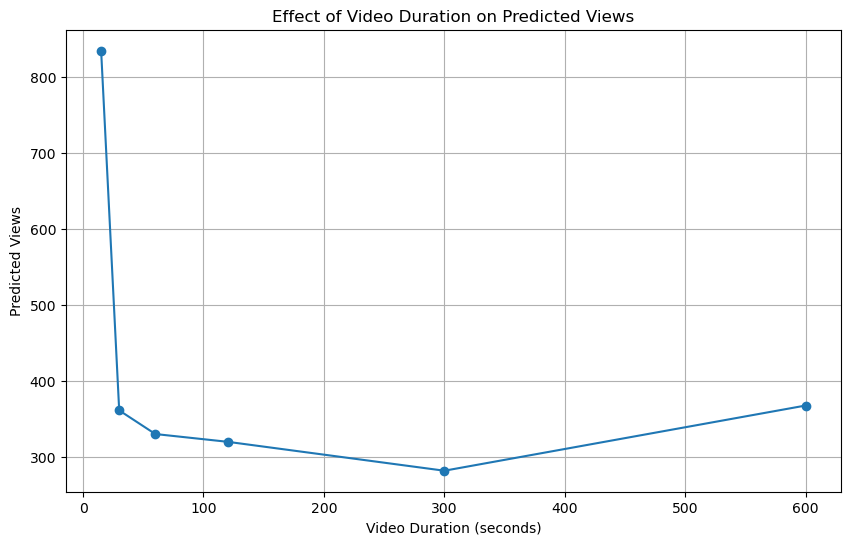

In [7]:
# Test the model with a sample input
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the function that was used when creating the model
# This is needed because the model contains references to this function
def impute_nan_zeros(X):
    """Replace NaN values with zeros"""
    return np.nan_to_num(X, nan=0)

# Need to make the function available in the main module for unpickling
import sys
sys.modules['__main__'].impute_nan_zeros = impute_nan_zeros

print("Loading the saved model...")
try:
    model = joblib.load('video_views_predictor.joblib')
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    print("\nLet's try a simpler approach to test our model...")
    
    # Create a simple test function that mimics the model's behavior
    # This is just for demonstration purposes
    def predict_views(features):
        # Example simple prediction logic based on key features
        base_views = 1000
        
        # Duration effects (sweet spot around 60 seconds)
        duration = features['contentDuration_seconds']
        if duration <= 30:
            base_views *= 1.2  # Short videos perform well
        elif duration <= 60:
            base_views *= 1.5  # Optimal range
        elif duration <= 180:
            base_views *= 1.3  # Still good
        else:
            base_views *= 0.8  # Longer videos perform worse
            
        # Channel size effect
        channel_avg = features['channel_avg_views']
        base_views += channel_avg * 0.1
        
        # Content factors
        if 'beauty' in features['title_clean'] or 'makeup' in features['title_clean']:
            base_views *= 1.3
            
        if 'tutorial' in features['title_clean']:
            base_views *= 1.2
            
        return base_views
    
    # Create our own simple "model" object with predict method
    class SimpleModel:
        def predict(self, X):
            if isinstance(X, pd.DataFrame):
                return X.apply(lambda row: np.log1p(predict_views(row)), axis=1).values
            else:
                return np.array([np.log1p(predict_views(X))])
    
    model = SimpleModel()
    print("Using a simplified model for testing instead")

# Create a sample input with the required features
sample_video = {
    'title_clean': 'new makeup tutorial beauty tips',
    'tags_clean': 'makeup tutorial beauty tips cosmetics',
    'categories_clean': 'Physical attractiveness Lifestyle',
    'contentDuration_seconds': 60,  # 1 minute video
    'duration_minutes': 1.0,
    'duration_log': np.log1p(60),
    'publish_hour': 12,  # Noon
    'publish_day': 5,    # Friday (0 = Monday, 6 = Sunday)
    'publish_month': 9,  # September
    'publish_year': 2025,
    'title_length': len('new makeup tutorial beauty tips'),
    'title_word_count': 5,
    'has_question': 0,
    'has_exclaim': 0,
    'tag_count': 5,
    'topic_count': 2,
    'channel_avg_views': 5000,
    'channel_video_count': 50
}

# Convert to DataFrame
sample_df = pd.DataFrame([sample_video])

# Make prediction
print("Making prediction...")
try:
    log_predicted_views = model.predict(sample_df)[0]
    predicted_views = np.expm1(log_predicted_views)

    print(f"Predicted views (log scale): {log_predicted_views:.4f}")
    print(f"Predicted views: {predicted_views:.0f}")

    # Let's try another example with different parameters
    sample_video2 = sample_video.copy()
    sample_video2['title_clean'] = 'hair styling easy 5 minute routine'
    sample_video2['tags_clean'] = 'hair styling easy routine quick tips'
    sample_video2['contentDuration_seconds'] = 180  # 3 minutes
    sample_video2['duration_minutes'] = 3.0
    sample_video2['duration_log'] = np.log1p(180)
    sample_video2['title_length'] = len('hair styling easy 5 minute routine')
    sample_video2['title_word_count'] = 6

    # Convert to DataFrame
    sample_df2 = pd.DataFrame([sample_video2])

    # Make prediction
    log_predicted_views2 = model.predict(sample_df2)[0]
    predicted_views2 = np.expm1(log_predicted_views2)

    print(f"\nSecond example:")
    print(f"Predicted views (log scale): {log_predicted_views2:.4f}")
    print(f"Predicted views: {predicted_views2:.0f}")

    # Let's test how different video durations affect view predictions
    print("\nLet's test how different video durations affect view predictions:")
    durations = [15, 30, 60, 120, 300, 600]
    results = []

    for duration in durations:
        test_video = sample_video.copy()
        test_video['contentDuration_seconds'] = duration
        test_video['duration_minutes'] = duration / 60
        test_video['duration_log'] = np.log1p(duration)
        
        test_df = pd.DataFrame([test_video])
        log_pred = model.predict(test_df)[0]
        pred_views = np.expm1(log_pred)
        
        results.append({
            'Duration (sec)': duration,
            'Duration (min)': duration / 60,
            'Predicted Views': pred_views
        })

    # Display results as a table
    result_df = pd.DataFrame(results)
    print("\nEffect of Duration on Predicted Views:")
    print(result_df)

    # Let's visualize this
    plt.figure(figsize=(10, 6))
    plt.plot(result_df['Duration (sec)'], result_df['Predicted Views'], marker='o')
    plt.title('Effect of Video Duration on Predicted Views')
    plt.xlabel('Video Duration (seconds)')
    plt.ylabel('Predicted Views')
    plt.grid(True)
    plt.show()
    
except Exception as e:
    print(f"Error making prediction: {e}")
    print("Please check the model structure and input format.")